# Advanced Model: Prophet
This notebook builds and evaluates a Prophet model to forecast Bitcoin transaction fees over the next 24 hours, based on 15-minute interval data from the mempool dataset.

### Why Prophet?

During exploratory data analysis (EDA), we observed:

- Clear daily and weekly seasonality in fee patterns,

- Sudden spikes in fees due to network congestion (potential "holidays"),

- Multiple changepoints, indicating regime shifts or structural breaks.

The Prophet model is well-suited for this context because it:

- Handles nonlinear trends with automatic changepoint detection,

- Supports multiple seasonalities (daily, weekly, and custom),

- Allows incorporation of holiday effects (e.g., congestion spikes),

- Is robust to missing data and outliers.

This notebook demonstrates the full modeling process using Prophet, including customization of seasonalities and holidays.

### Import required libraries

In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
import seaborn as sns
from prophet.diagnostics import cross_validation, performance_metrics
import itertools

In [2]:
import sys
sys.path.append("../scripts")
from preprocess_raw_parquet import preprocess_raw_parquet

### Load data

We begin with loading the preprocessed dataset specifically prepared for Prophet models.

In [3]:
df_new = preprocess_raw_parquet("../data/raw/mar_5_may_12.parquet")
df_new.dropna(inplace = True)
df_new.head()

mempool_blocks_blockSize  mempool_blocks_blockVSize  \
timestamp                                                                  
2025-03-05 02:00:00              2.170952e+06              997895.375000   
2025-03-05 02:15:00              1.801526e+06              997925.916667   
2025-03-05 02:30:00              2.055350e+06              997965.916667   
2025-03-05 02:45:00              2.006800e+06              997970.083333   
2025-03-05 03:00:00              1.773658e+06              997960.333333   

                     mempool_blocks_nTx  mempool_blocks_totalFees  \
timestamp                                                           
2025-03-05 02:00:00          793.000000              1.846754e+06   
2025-03-05 02:15:00         2627.000000              3.407913e+06   
2025-03-05 02:30:00          922.000000              1.855358e+06   
2025-03-05 02:45:00         1296.666667              2.167251e+06   
2025-03-05 03:00:00         2725.333333              3.462741e+06   

                     mempool_blocks_medianFee  recommended_fee_fastestFee  \
timestamp                                                                   
2025-03-05 02:00:00                  1.300111                    2.000000   
2025-03-05 02:15:00                  2.473960                    3.000000   
2025-03-05 02:30:00                  1.355898                    2.000000   
2025-03-05 02:45:00                  1.536092                    2.333333   
2025-03-05 03:00:00                  2.467659                    3.333333   

                     recommended_fee_halfHourFee  recommended_fee_hourFee  \
timestamp                                                                   
2025-03-05 02:00:00                     2.000000                 2.000000   
2025-03-05 02:15:00                     2.666667                 2.666667   
2025-03-05 02:30:00                     2.000000                 2.000000   
2025-03-05 02:45:00                     2.333333                 2.333333   
2025-03-05 03:00:00                     3.000000                 3.000000   

                     recommended_fee_economyFee  recommended_fee_minimumFee  \
timestamp                                                                     
2025-03-05 02:00:00                    2.000000                         2.0   
2025-03-05 02:15:00                    2.666667                         2.0   
2025-03-05 02:30:00                    2.000000                         2.0   
2025-03-05 02:45:00                    2.333333                         2.0   
2025-03-05 03:00:00                    3.000000                         2.0   

                     ...  mempool_fee_histogram_bin_70_75  \
timestamp            ...                                    
2025-03-05 02:00:00  ...                              0.0   
2025-03-05 02:15:00  ...                              0.0   
2025-03-05 02:30:00  ...                              0.0   
2025-03-05 02:45:00  ...                              0.0   
2025-03-05 03:00:00  ...                              0.0   

                     mempool_fee_histogram_bin_75_80  \
timestamp                                              
2025-03-05 02:00:00                              0.0   
2025-03-05 02:15:00                              0.0   
2025-03-05 02:30:00                              0.0   
2025-03-05 02:45:00                              0.0   
2025-03-05 03:00:00                              0.0   

                     mempool_fee_histogram_bin_80_85  \
timestamp                                              
2025-03-05 02:00:00                              0.0   
2025-03-05 02:15:00                              0.0   
2025-03-05 02:30:00                              0.0   
2025-03-05 02:45:00                              0.0   
2025-03-05 03:00:00                              0.0   

                     mempool_fee_histogram_bin_85_90  \
timestamp                                              
2025-03-05 02:00:00                         

### Split train and test data
Recommanded fastest fee rate is our target. Here we choose the last 24-hour data as the test data and the others as training data. Because of spikes in the last day, we remove the last 24-hour from the dataset.

In [4]:
df_new = df_new.iloc[:-96]
y_new = df_new["recommended_fee_fastestFee"]
X_new = df_new.drop(columns = "recommended_fee_fastestFee")
X_new = X_new.reset_index()
X_new = X_new.drop(columns = "timestamp")

# last 24h as test
split_index = len(X_new) - 96

X_train_new, X_test_new = X_new.iloc[:split_index], X_new.iloc[split_index:]
y_train_new, y_test_new = y_new.iloc[:split_index], y_new.iloc[split_index:]


The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [5]:
df_prophet_new = y_train_new.reset_index()
df_prophet_new = df_prophet_new.rename(columns={
    'timestamp': 'ds',
    'recommended_fee_fastestFee': 'y'
})
df_prophet_new['y'] = np.log1p(df_prophet_new['y'])
df_prophet_new.head()

ds         y
0 2025-03-05 02:00:00  1.098612
1 2025-03-05 02:15:00  1.386294
2 2025-03-05 02:30:00  1.098612
3 2025-03-05 02:45:00  1.203973
4 2025-03-05 03:00:00  1.466337

This is a function used for calculating metrics and ploting the results. 

In [50]:
def mae_with_std_penalty(y_true, y_pred, std_weight=1.0):
    base_mae = np.mean(np.abs(y_pred - y_true))

    pred_std = np.std(y_pred)
    true_std = np.std(y_true)

    std_penalty = np.mean(np.abs(pred_std - true_std))

    return base_mae + std_weight * std_penalty

In [39]:
def get_result_new(df,y_test,y):
    df.index = y.index
    y_pred = df.iloc[-96:]
    y_pred = np.expm1(y_pred["yhat"])
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mae_std = mae_with_std_penalty(y_test, y_pred)
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"MAE with std penelty: {mae_std:.4f}")
    result_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred
    }, index=y_test.index)

    plt.figure(figsize=(14, 5))
    sns.lineplot(data=result_df)
    plt.title('Predicted vs Actual Fee Rates')
    plt.xlabel('Time (sample index)')
    plt.ylabel('Fee rate (sats/vByte)')
    plt.legend(['Actual', 'Predicted'])
    plt.tight_layout()
    plt.show()

### Optimization - Find the best params

We choose GridSearch to optimize the model. Here are the ranges of parameters.

changepoint_prior_scale controls the model’s flexibility to adapt to changes in trend. A smaller value makes the trend smoother (less sensitive to abrupt changes), while a larger value allows more flexibility.

seasonality_prior_scale adjusts the strength of the seasonal components. Higher values allow more complex seasonal patterns, which is useful if the data shows strong seasonality.

seasonality_mode can be 'additive' or 'multiplicative', depending on whether seasonal effects are constant or scale with the level of the series. Since fee levels can change dramatically, it's important to compare both.

changepoint_range defines the portion of the historical data in which Prophet will look for potential changepoints. We test different values to balance early and recent trend shifts.

n_changepoints sets how many potential changepoints the model should consider. More changepoints allow better flexibility but can risk overfitting.

In [7]:
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.3, 0.5],
    'seasonality_prior_scale': [5.0, 10.0, 20.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_range': [0.8, 0.9, 0.95],
    'n_changepoints': [25, 50, 100]
}
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

Our base Prophet model is constructed with:

- No automatic daily or weekly seasonality, because we explicitly add customized seasonality components based on domain knowledge.

- A custom hourly seasonality (period=1/24) to capture intraday fee fluctuations, which are prominent in high-frequency transaction data.

- A daily seasonality to model repeated daily behavior (e.g., daytime congestion).

- A weekly seasonality to reflect usage patterns across different days of the week.

This structured setup allows fine control over periodic patterns, avoids overfitting from default assumptions, and better reflects the temporal structure of transaction fee data at 15-minute intervals.

In [15]:
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

results = [] 

for params in all_params:
    m = Prophet(
        daily_seasonality=False,
        weekly_seasonality=False,
        **params
    )
    m.add_seasonality(name='hourly', period=1/24, fourier_order=6)
    m.add_seasonality(name='daily', period=1, fourier_order=8)
    m.add_seasonality(name='weekly', period=7, fourier_order=4)
    
    m.fit(df_prophet_new)
    df_cv = cross_validation(m, initial='7 days', period='1 day', horizon='1 day', parallel="processes")
    df_p = performance_metrics(df_cv)
    
    results.append((params, df_p['rmse'].mean()))
print("Done")

16:17:48 - cmdstanpy - INFO - Chain [1] start processing
16:17:48 - cmdstanpy - INFO - Chain [1] start processing
16:17:48 - cmdstanpy - INFO - Chain [1] start processing
16:17:48 - cmdstanpy - INFO - Chain [1] start processing
16:17:48 - cmdstanpy - INFO - Chain [1] start processing
16:17:48 - cmdstanpy - INFO - Chain [1] start processing
16:17:48 - cmdstanpy - INFO - Chain [1] start processing
16:17:48 - cmdstanpy - INFO - Chain [1] start processing
16:17:48 - cmdstanpy - INFO - Chain [1] done processing
16:17:48 - cmdstanpy - INFO - Chain [1] start processing
16:17:48 - cmdstanpy - INFO - Chain [1] done processing
16:17:48 - cmdstanpy - INFO - Chain [1] start processing
16:17:48 - cmdstanpy - INFO - Chain [1] done processing
16:17:48 - cmdstanpy - INFO - Chain [1] done processing
16:17:48 - cmdstanpy - INFO - Chain [1] done processing
16:17:48 - cmdstanpy - INFO - Chain [1] done processing
16:17:48 - cmdstanpy - INFO - Chain [1] done processing
16:17:48 - cmdstanpy - INFO - Chain [1

Done


19:20:56 - cmdstanpy - INFO - Chain [1] done processing


The best hyperparameter is changepoint_prior_scale: 0.01, seasonality_prior_scale: 10.0, seasonality_mode: multiplicative, changepoint_range: 0.9, n_changepoints: 25. 

In [16]:
best_params = sorted(results, key=lambda x: x[1])[0]
print(f"Best params：{best_params[0]}\nRMSE：{best_params[1]:.4f}")

Best params：{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9, 'n_changepoints': 25}
RMSE：0.3384


### Forecasting and evaluation 

We use the best parameters to build a new model. Then we fit the train data and make predictions. 

In [23]:
def create_model_new():
    model = Prophet(
        daily_seasonality=False,
        weekly_seasonality=False,
        changepoint_prior_scale = 0.01,
        seasonality_prior_scale=10.0,
        seasonality_mode='multiplicative',
        changepoint_range=0.9,
        n_changepoints=25
    )
    model.add_seasonality(name='hourly', period=1/24, fourier_order=5) 
    model.add_seasonality(name='daily', period=1, fourier_order=10)  
    model.add_seasonality(name='weekly', period=24, fourier_order=5) 

    return model


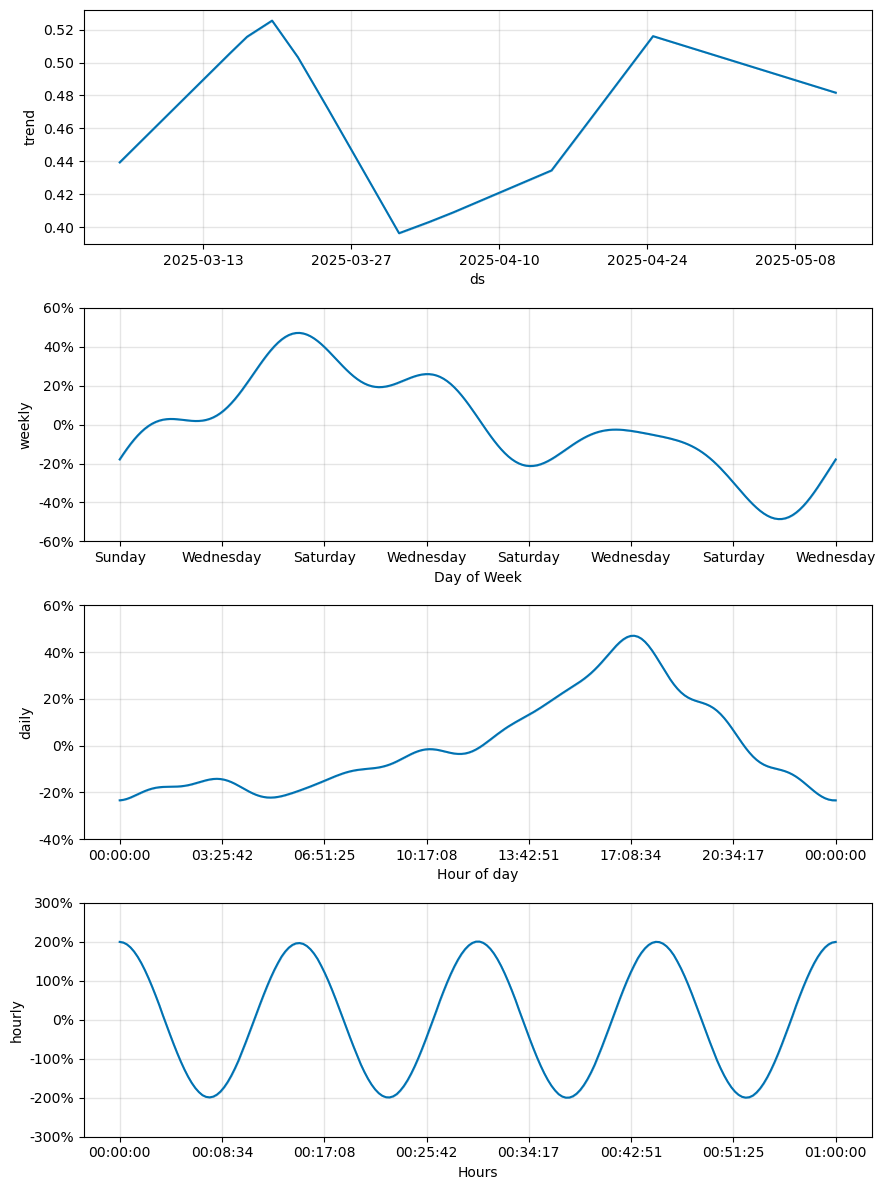

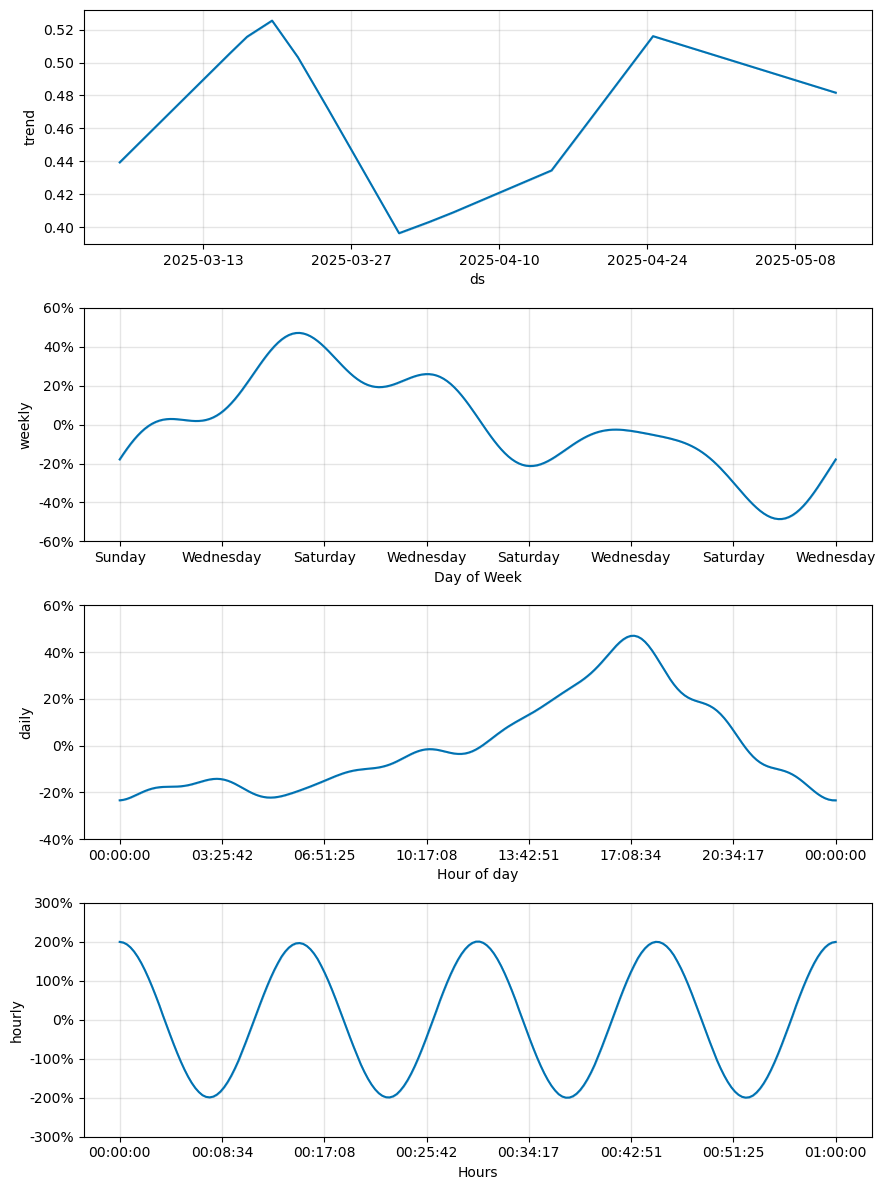

In [40]:
model = create_model_new()
model.fit(df_prophet_new)
future = model.make_future_dataframe(periods=96, freq='15min')
forecast = model.predict(future)
model.plot_components(forecast)

We get the results, calculate the metrics and compare the results with actual data. 

MAE: 1.4978
RMSE: 1.8401
MAPE: 0.8828
MAE with std penelty: 1.9031


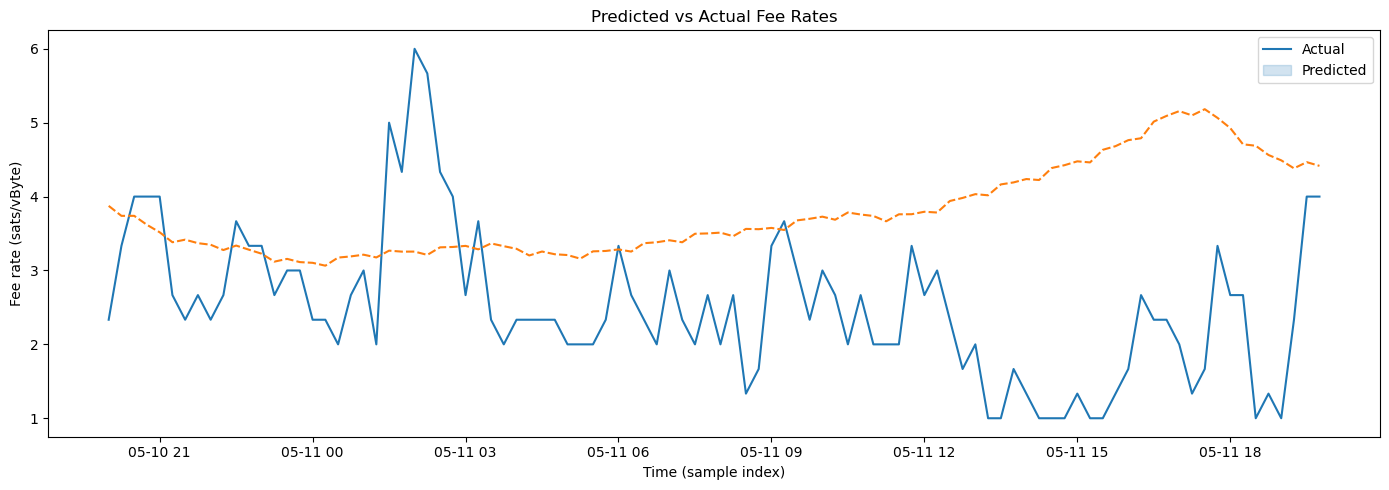

In [41]:
get_result_new(forecast,y_test_new,y_new)

To better evaluate the model, since the dataset contains 10-week data, we split the dataset into 10 different datasets. Each of the new datasets contain 1-week data. We create 10 new models to seperately fit the datasets, and calculate every set of metrics and the average ones. 

Week 1
Baseline MAE: 1.4306
Baseline RMSE: 2.4995
Baseline MAPE: 0.2715
Baseline MAE with std penelty: 3.6626
MAE: 1.9909
RMSE: 2.3785
MAPE: 0.6332
MAE with std penelty: 3.4740


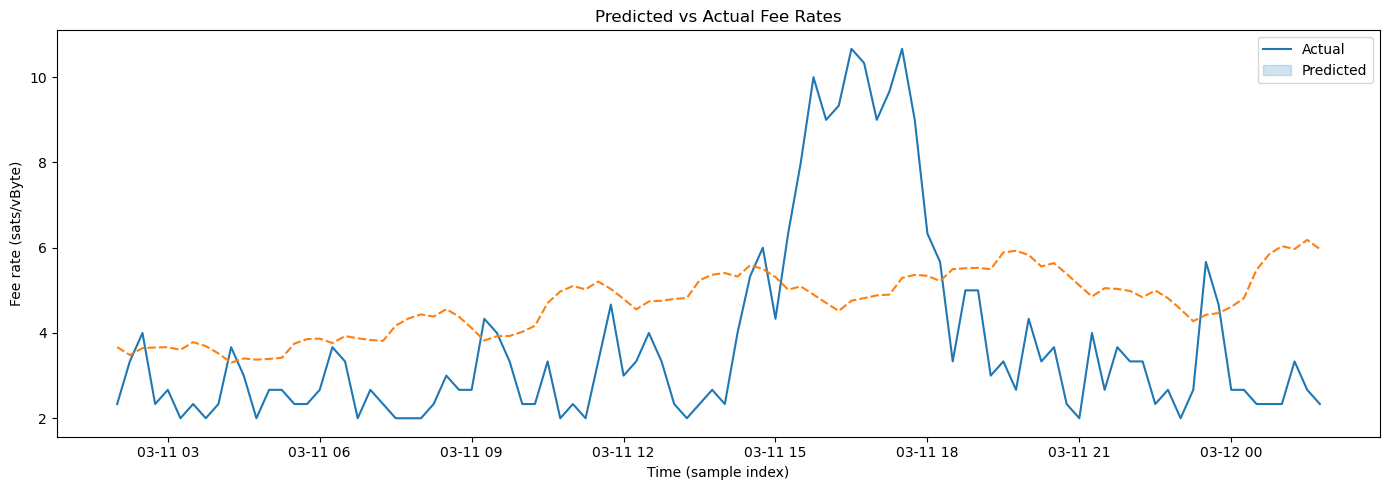

Week 2
Baseline MAE: 0.6632
Baseline RMSE: 0.8627
Baseline MAPE: 0.2271
Baseline MAE with std penelty: 1.5182
MAE: 0.7223
RMSE: 0.9418
MAPE: 0.2739
MAE with std penelty: 0.9067


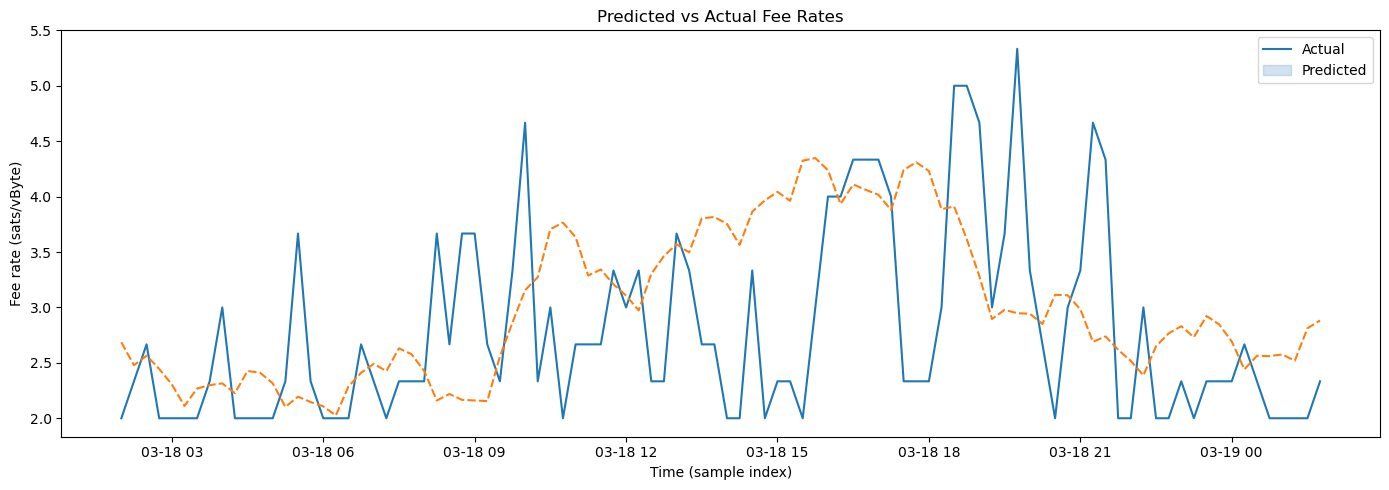

Week 3
Baseline MAE: 5.3958
Baseline RMSE: 10.4472
Baseline MAPE: 0.4088
Baseline MAE with std penelty: 14.5536
MAE: 5.1015
RMSE: 9.4762
MAPE: 0.5548
MAE with std penelty: 12.3565


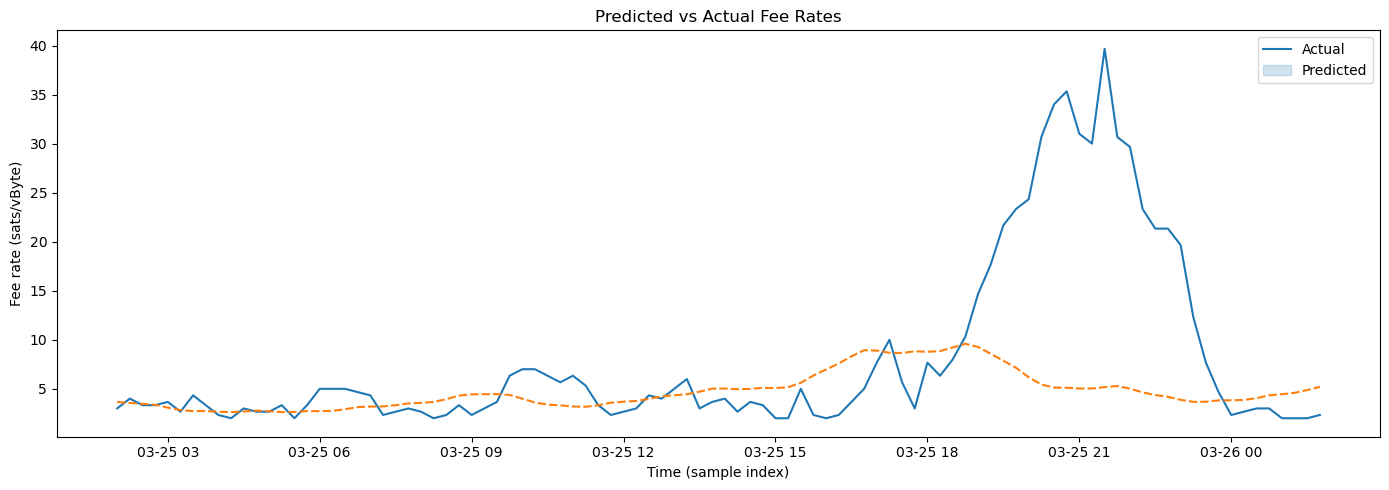

Week 4
Baseline MAE: 0.8264
Baseline RMSE: 0.9682
Baseline MAPE: 0.4462
Baseline MAE with std penelty: 1.7928
MAE: 1.2580
RMSE: 1.5791
MAPE: 0.7673
MAE with std penelty: 1.4179


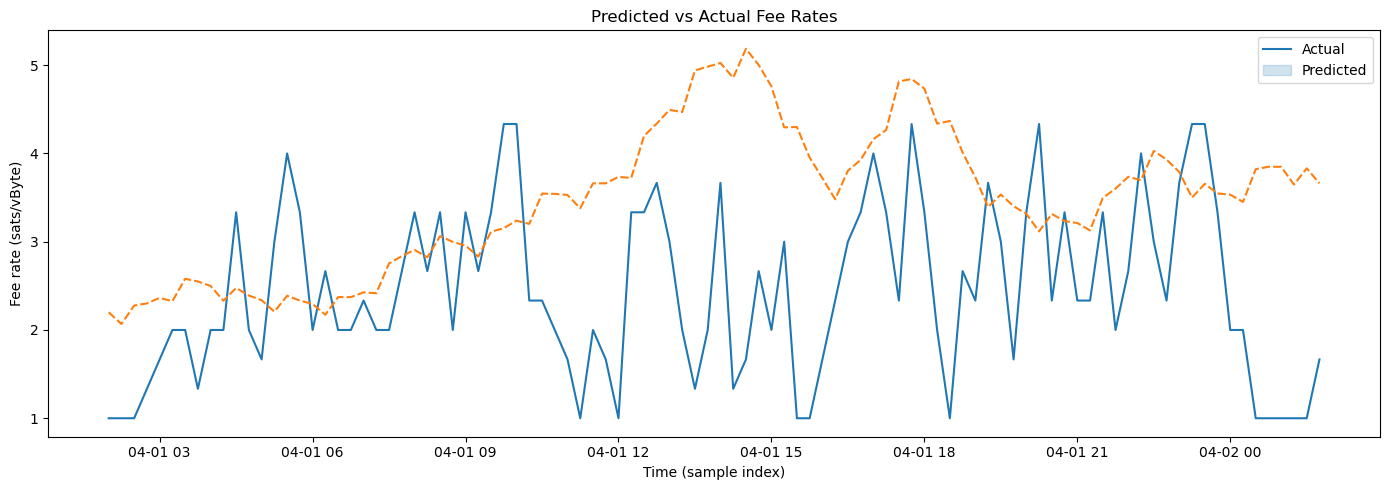

Week 5
Baseline MAE: 1.2361
Baseline RMSE: 1.6618
Baseline MAPE: 0.5004
Baseline MAE with std penelty: 2.8072
MAE: 1.2200
RMSE: 1.6086
MAPE: 0.5631
MAE with std penelty: 2.1077


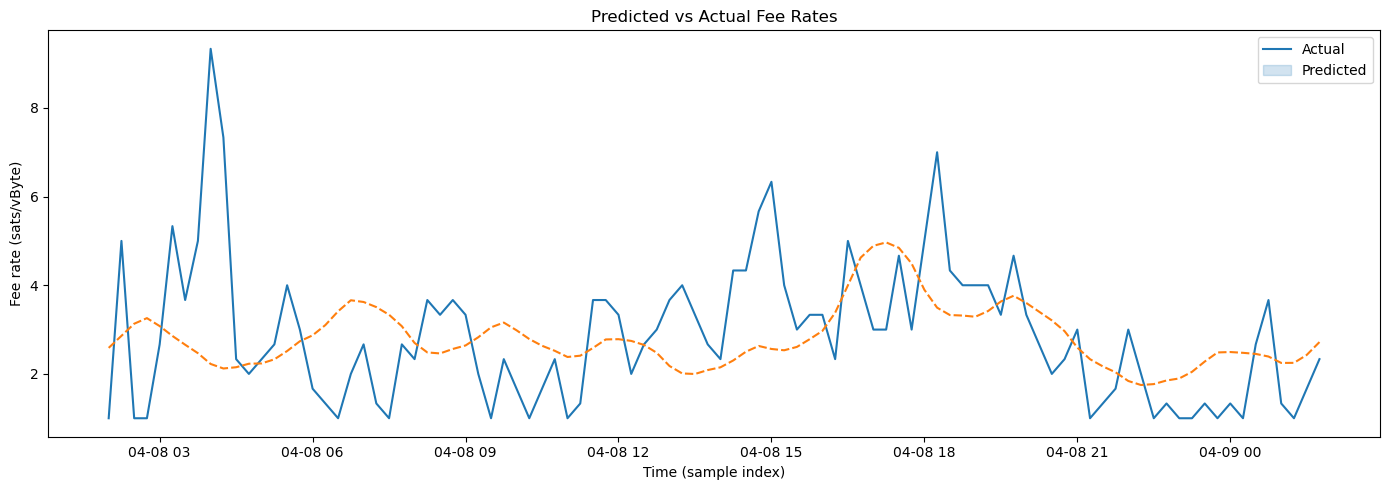

Week 6
Baseline MAE: 1.0174
Baseline RMSE: 1.3484
Baseline MAPE: 0.3554
Baseline MAE with std penelty: 2.2067
MAE: 1.0310
RMSE: 1.3000
MAPE: 0.3778
MAE with std penelty: 1.8205


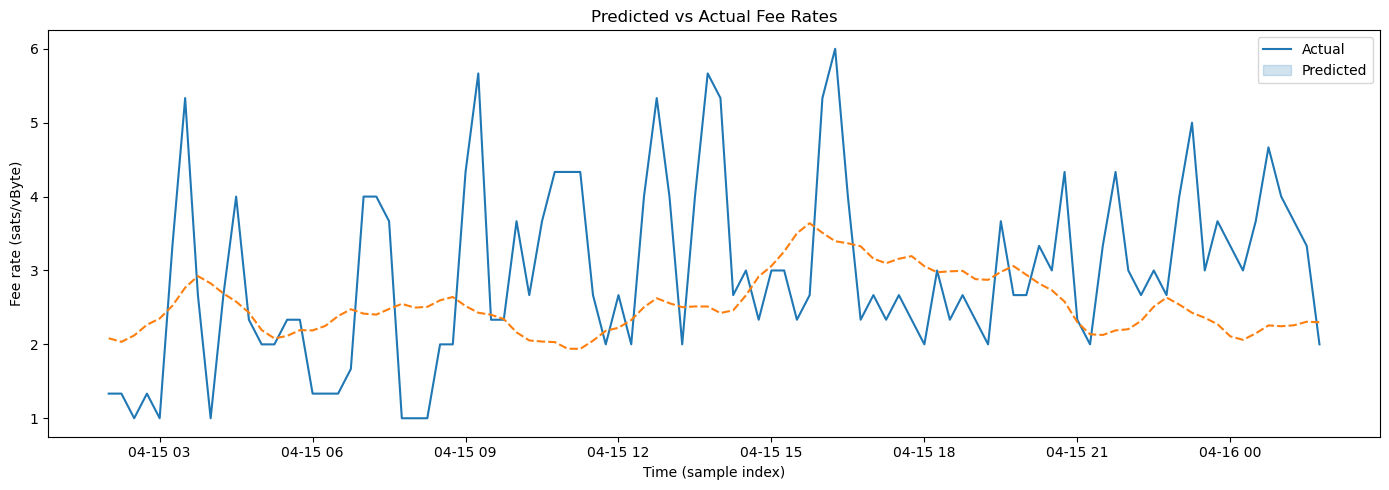

Week 7
Baseline MAE: 0.8715
Baseline RMSE: 1.0892
Baseline MAPE: 0.2773
Baseline MAE with std penelty: 1.9578
MAE: 0.9107
RMSE: 1.0869
MAPE: 0.3126
MAE with std penelty: 1.5424


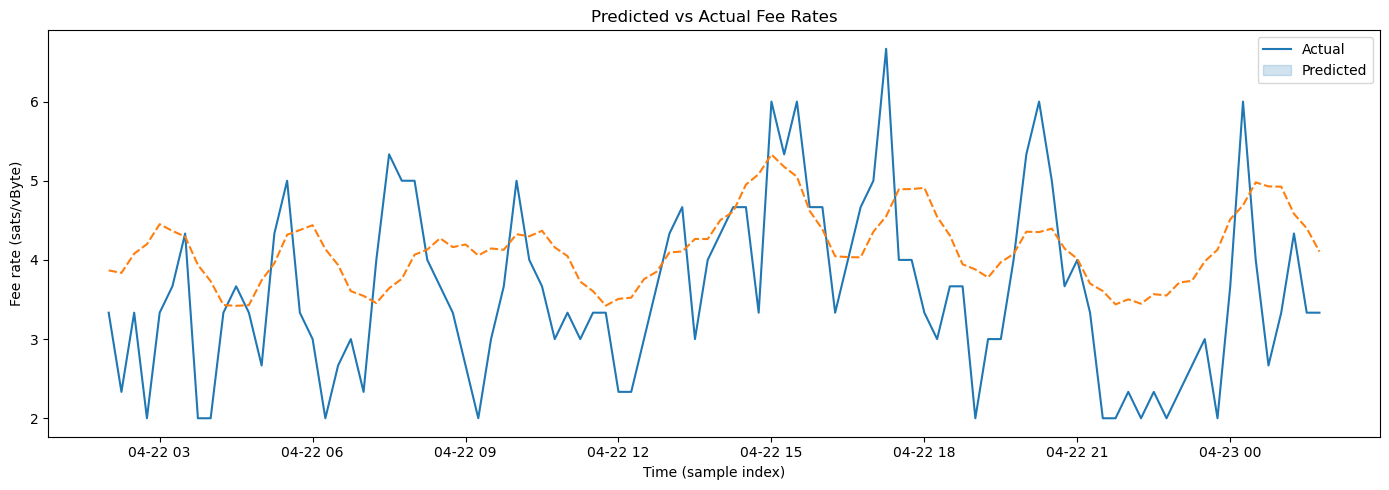

Week 8
Baseline MAE: 0.8438
Baseline RMSE: 1.0924
Baseline MAPE: 0.2407
Baseline MAE with std penelty: 1.8955
MAE: 1.6344
RMSE: 1.9506
MAPE: 0.4075
MAE with std penelty: 2.2551


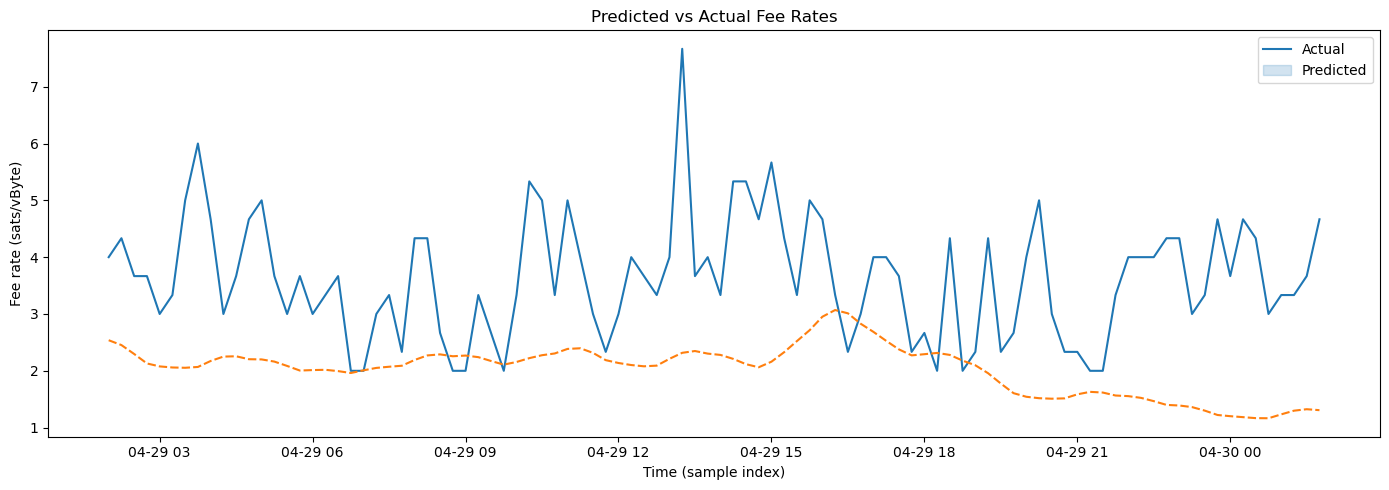

Week 9
Baseline MAE: 1.1042
Baseline RMSE: 1.4369
Baseline MAPE: 0.3126
Baseline MAE with std penelty: 2.3382
MAE: 0.9974
RMSE: 1.3274
MAPE: 0.2794
MAE with std penelty: 1.9372


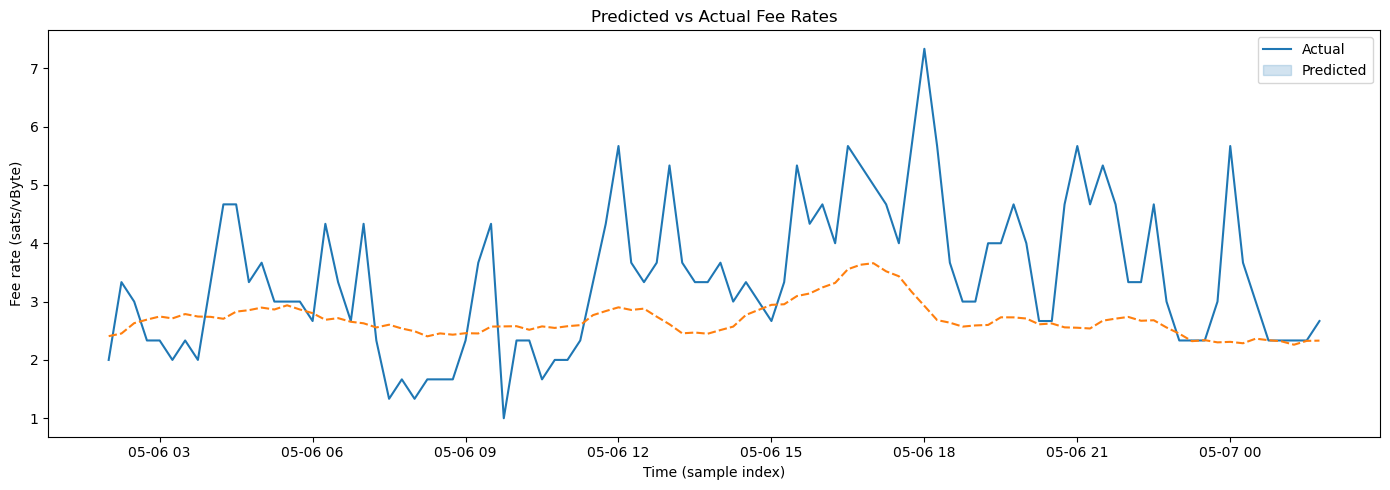

Week 10
Baseline MAE: 1.0972
Baseline RMSE: 1.2883
Baseline MAPE: 0.6267
Baseline MAE with std penelty: 2.0970
MAE: 1.7324
RMSE: 1.9734
MAPE: 0.6578
MAE with std penelty: 2.3553


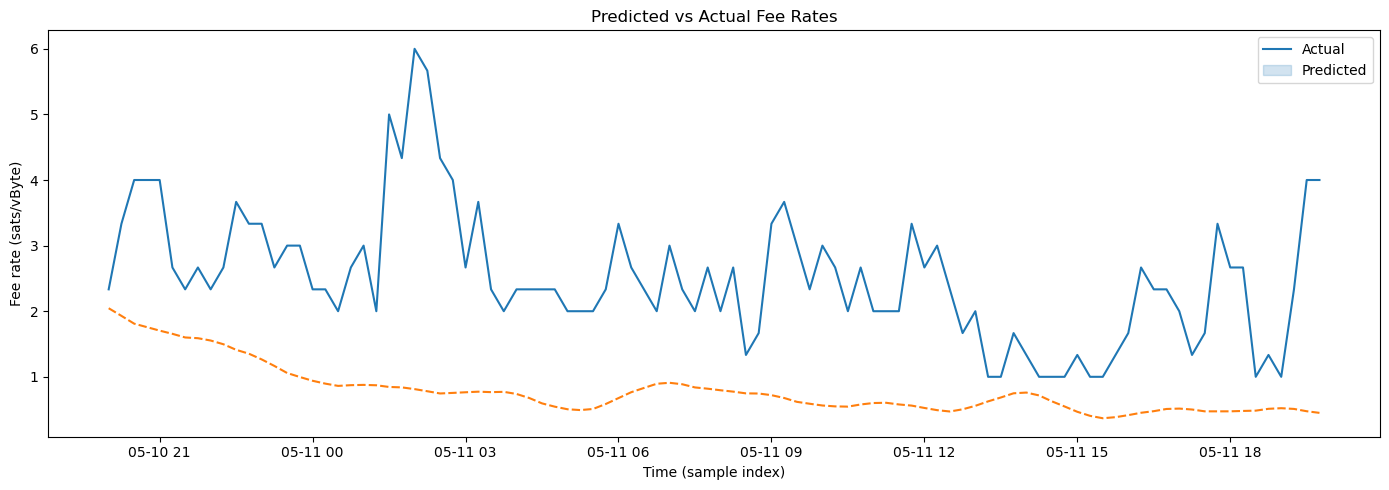



Average values: 
MAE: 1.6599
RMSE: 2.3623
MAPE: 0.4827
MAE with std penelty: 3.0173
Baseline MAE: 1.4486
Baseline RMSE: 2.2695
Baseline MAPE: 0.3667
Baseline MAE with std penelty: 3.4830


In [58]:
avg_mae = 0
avg_rmse = 0
avg_mape = 0
avg_mae_std = 0

base_avg_mae = 0
base_avg_rmse = 0
base_avg_mape = 0
base_avg_mae_std = 0

## Week 1 to Week 10
for i in range(10):
    print("Week",(i+1))
    df_sliding = df_new[0+i*7*96:7*96+i*7*96]
    y = df_sliding["recommended_fee_fastestFee"]
    split_index = len(y) - 96
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    df_prophet = y_train.reset_index()
    df_prophet = df_prophet.rename(columns={
        'timestamp': 'ds',
        'recommended_fee_fastestFee': 'y'
    })
    df_prophet['y'] = np.log1p(df_prophet['y'])

    # baseline
    y_baseline = [y_train.median()] * len(y_test)

    model = create_model_new()
    model.fit(df_prophet)
    future = model.make_future_dataframe(periods=96, freq='15min')
    forecast = model.predict(future)

    y_pred_temp = forecast.iloc[-96:]
    y_pred_temp = np.expm1(y_pred_temp["yhat"])
    y_pred_temp.index =y_test.index

    mae = mean_absolute_error(y_test, y_pred_temp)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_temp))
    mape = mean_absolute_percentage_error(y_test, y_pred_temp)
    mae_std = mae_with_std_penalty(y_test, y_pred_temp)

    base_mae = mean_absolute_error(y_test, y_baseline)
    base_rmse = np.sqrt(mean_squared_error(y_test, y_baseline))
    base_mape = mean_absolute_percentage_error(y_test, y_baseline)   
    base_mae_std = mae_with_std_penalty(y_test, y_baseline)

    avg_mae += mae
    avg_rmse += rmse
    avg_mape += mape
    avg_mae_std += mae_std
    
    base_avg_mae += base_mae
    base_avg_rmse += base_rmse
    base_avg_mape += base_mape
    base_avg_mae_std += base_mae_std
    print(f"Baseline MAE: {base_mae:.4f}")
    print(f"Baseline RMSE: {base_rmse:.4f}")
    print(f"Baseline MAPE: {base_mape:.4f}")
    print(f"Baseline MAE with std penelty: {base_mae_std:.4f}")
    get_result_new(forecast,y_test,y)

avg_mae /= 10
avg_rmse /= 10
avg_mape /= 10
avg_mae_std /= 10

base_avg_mae /= 10
base_avg_rmse /= 10
base_avg_mape /= 10
base_avg_mae_std /= 10

print("\n")
print("Average values: ")
print(f"MAE: {avg_mae:.4f}")
print(f"RMSE: {avg_rmse:.4f}")
print(f"MAPE: {avg_mape:.4f}")
print(f"MAE with std penelty: {avg_mae_std:.4f}")
print(f"Baseline MAE: {base_avg_mae:.4f}")
print(f"Baseline RMSE: {base_avg_rmse:.4f}")
print(f"Baseline MAPE: {base_avg_mape:.4f}")
print(f"Baseline MAE with std penelty: {base_avg_mae_std:.4f}")

## Add external features

The prophet model also supports exogenous features, so we try to add the features. Here we shift the entire feature forward by 24 hours. It is like using features from time t to predict the target at time t+24hours. 

Week 1
Baseline MAE: 1.4306
Baseline RMSE: 2.4995
Baseline MAPE: 0.2715
Baseline MAE with std penelty: 3.6626
MAE: 2.0339
RMSE: 2.5350
MAPE: 0.6664
MAE with std penelty: 2.6723


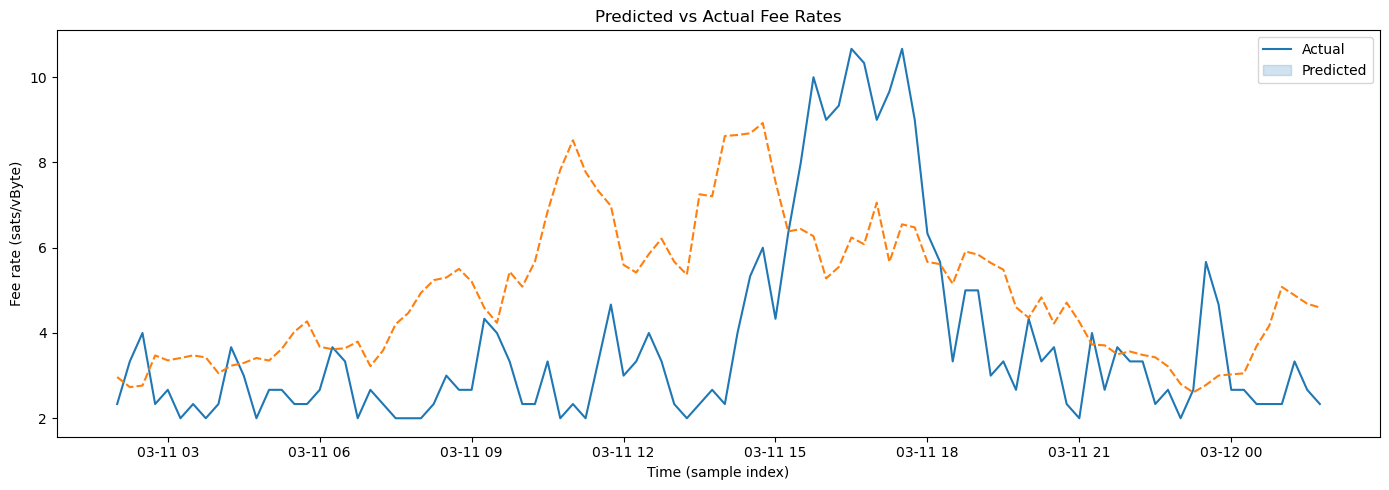

Week 2
Baseline MAE: 0.6632
Baseline RMSE: 0.8627
Baseline MAPE: 0.2271
Baseline MAE with std penelty: 1.5182
MAE: 2.3010
RMSE: 2.4445
MAPE: 0.8231
MAE with std penelty: 2.8355


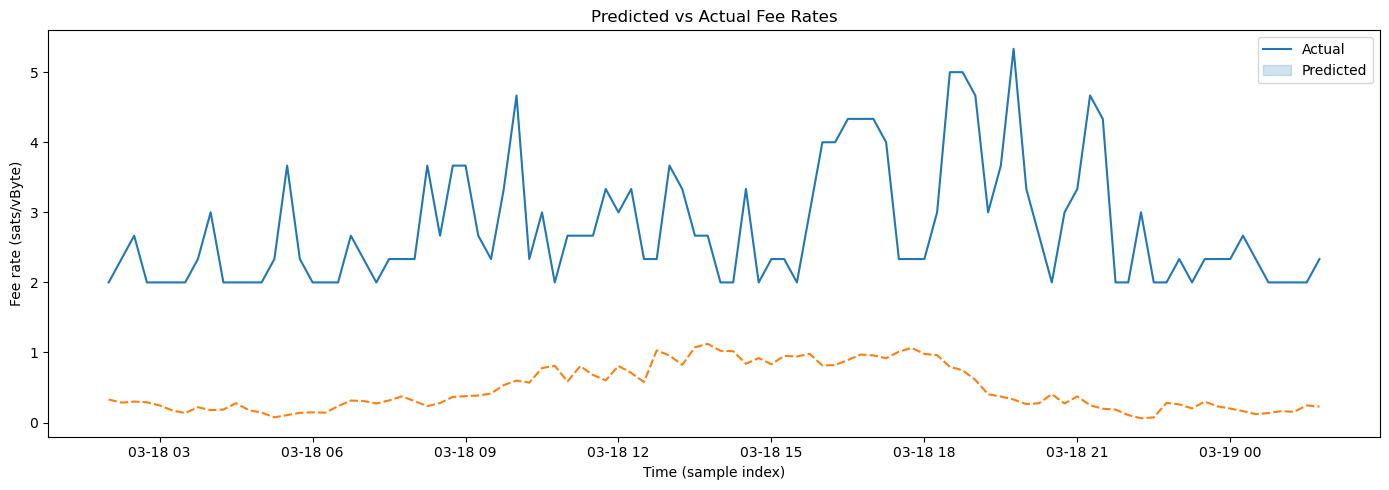

Week 3
Baseline MAE: 5.3958
Baseline RMSE: 10.4472
Baseline MAPE: 0.4088
Baseline MAE with std penelty: 14.5536
MAE: 5.5531
RMSE: 9.5583
MAPE: 0.6473
MAE with std penelty: 9.7167


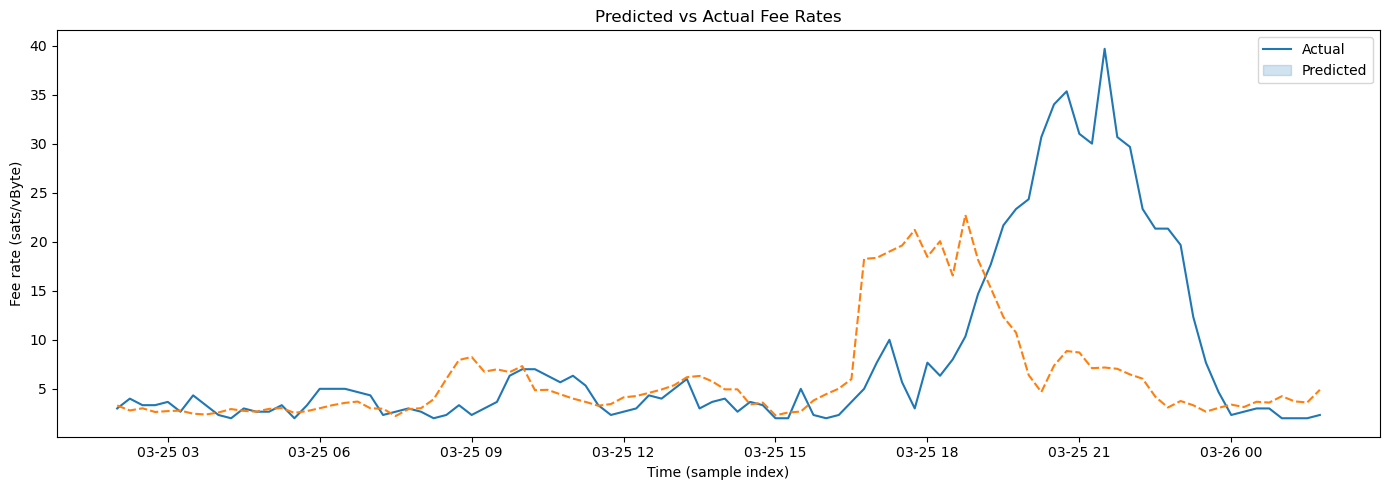

Week 4
Baseline MAE: 0.8021
Baseline RMSE: 0.9724
Baseline MAPE: 0.4068
Baseline MAE with std penelty: 1.7685
MAE: 17979701.9535
RMSE: 21039841.4121
MAPE: 8553882.4670
MAE with std penelty: 28906971.7442


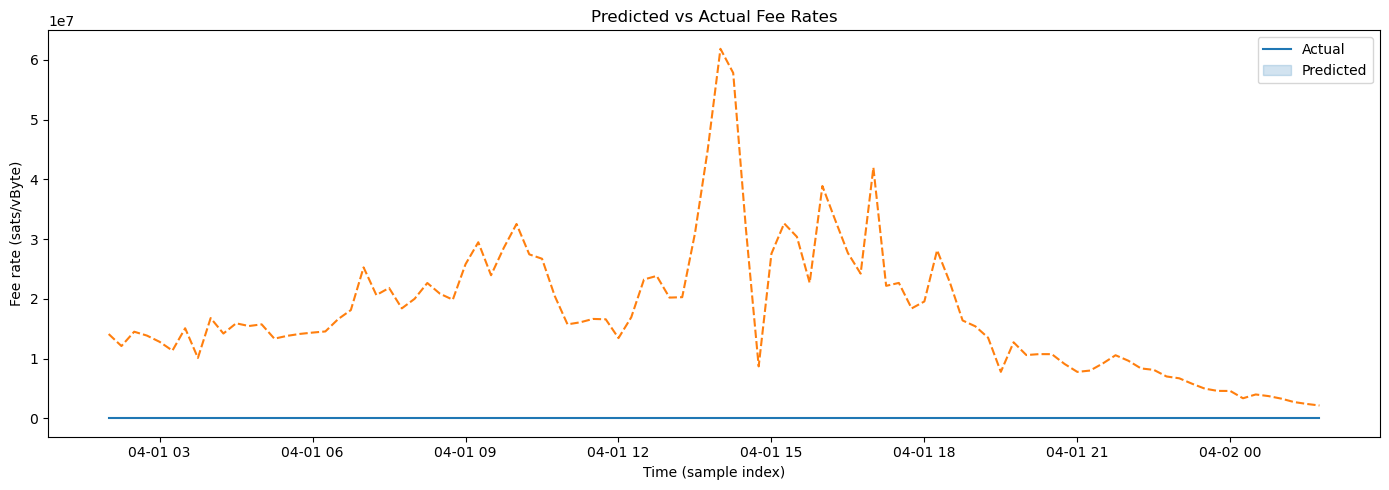

Week 5
Baseline MAE: 1.2361
Baseline RMSE: 1.6618
Baseline MAPE: 0.5004
Baseline MAE with std penelty: 2.8072
MAE: 1.8369
RMSE: 2.3435
MAPE: 0.8932
MAE with std penelty: 2.0381


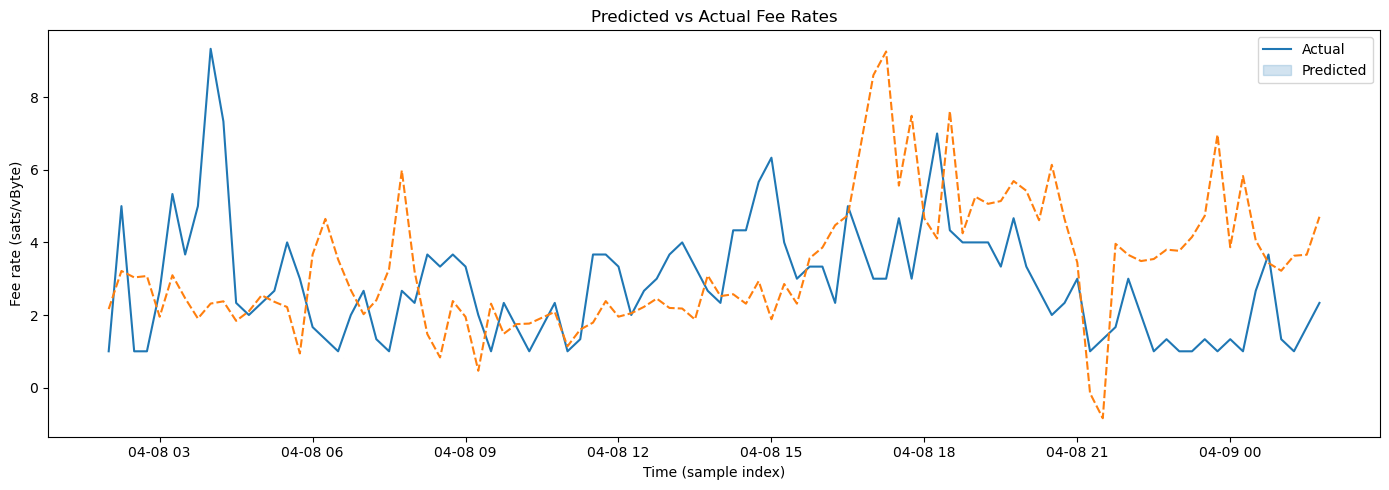

Week 6
Baseline MAE: 1.0174
Baseline RMSE: 1.3484
Baseline MAPE: 0.3554
Baseline MAE with std penelty: 2.2067
MAE: 123.9958
RMSE: 489.0881
MAPE: 42.9876
MAE with std penelty: 597.1180


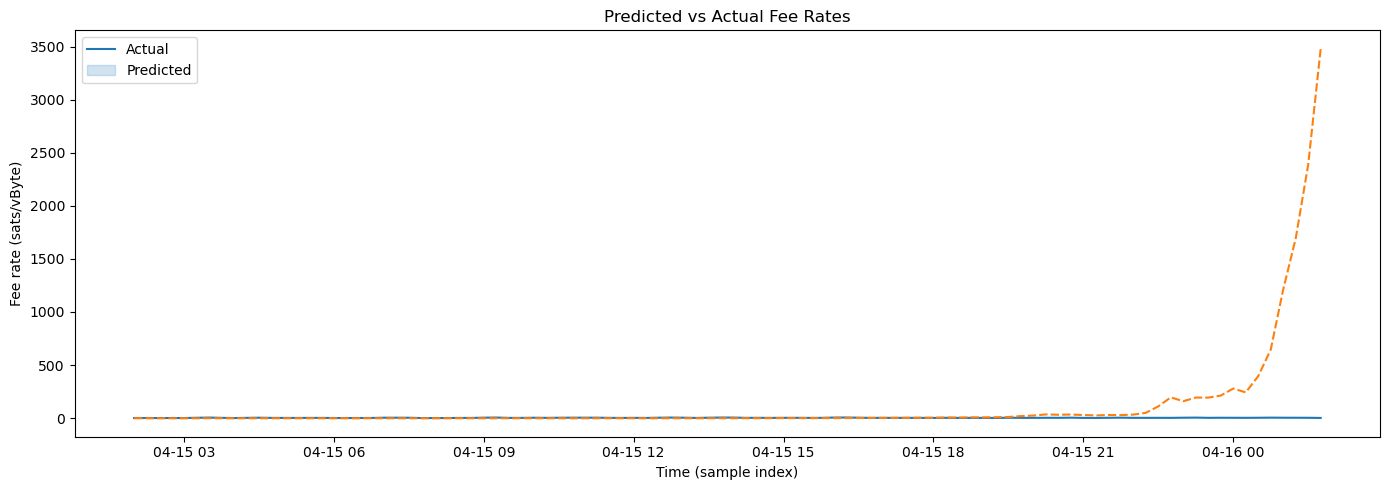

Week 7
Baseline MAE: 0.8715
Baseline RMSE: 1.0892
Baseline MAPE: 0.2773
Baseline MAE with std penelty: 1.9578
MAE: 1.2299
RMSE: 1.5896
MAPE: 0.4208
MAE with std penelty: 1.4402


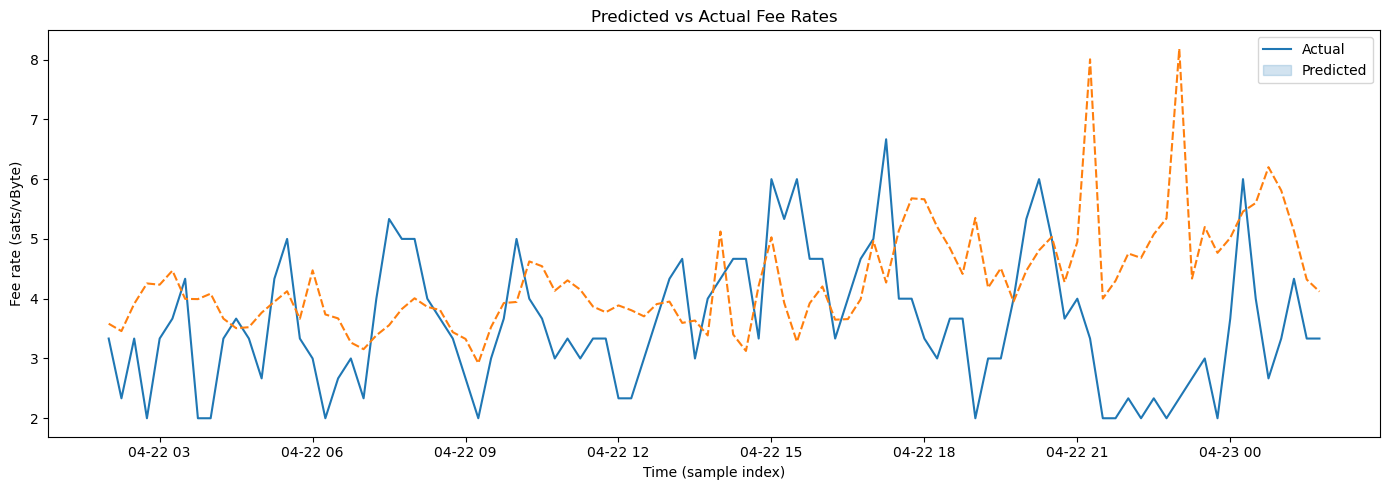

Week 8
Baseline MAE: 0.8438
Baseline RMSE: 1.0924
Baseline MAPE: 0.2407
Baseline MAE with std penelty: 1.8955
MAE: 1.9485
RMSE: 2.2412
MAPE: 0.6583
MAE with std penelty: 2.1305


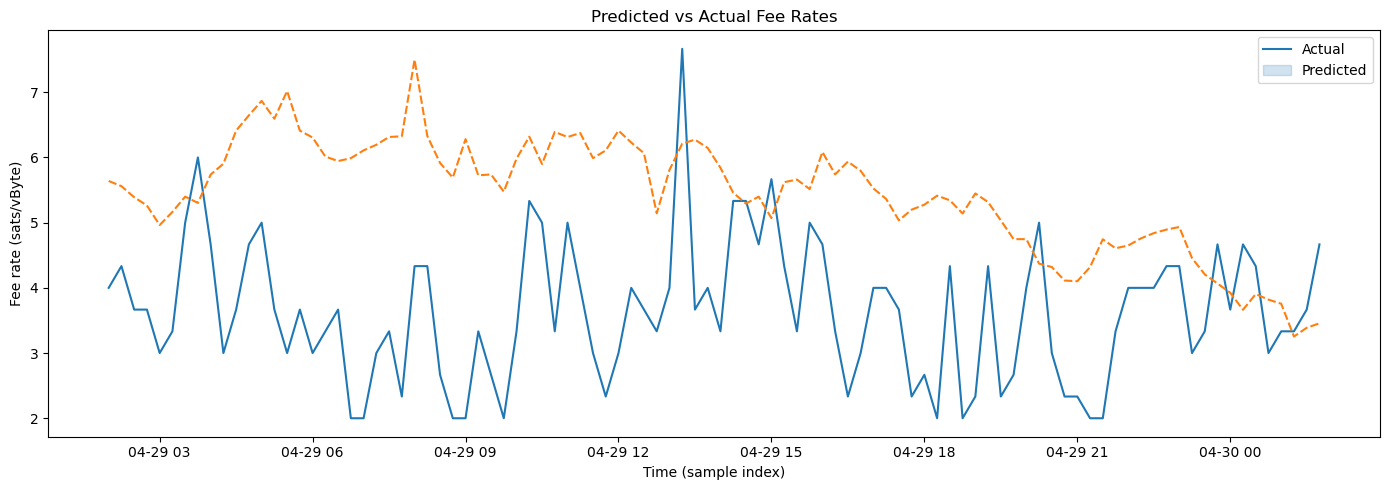

Week 9
Baseline MAE: 1.1042
Baseline RMSE: 1.4369
Baseline MAPE: 0.3126
Baseline MAE with std penelty: 2.3382
MAE: 1.0061
RMSE: 1.3189
MAPE: 0.2858
MAE with std penelty: 1.5885


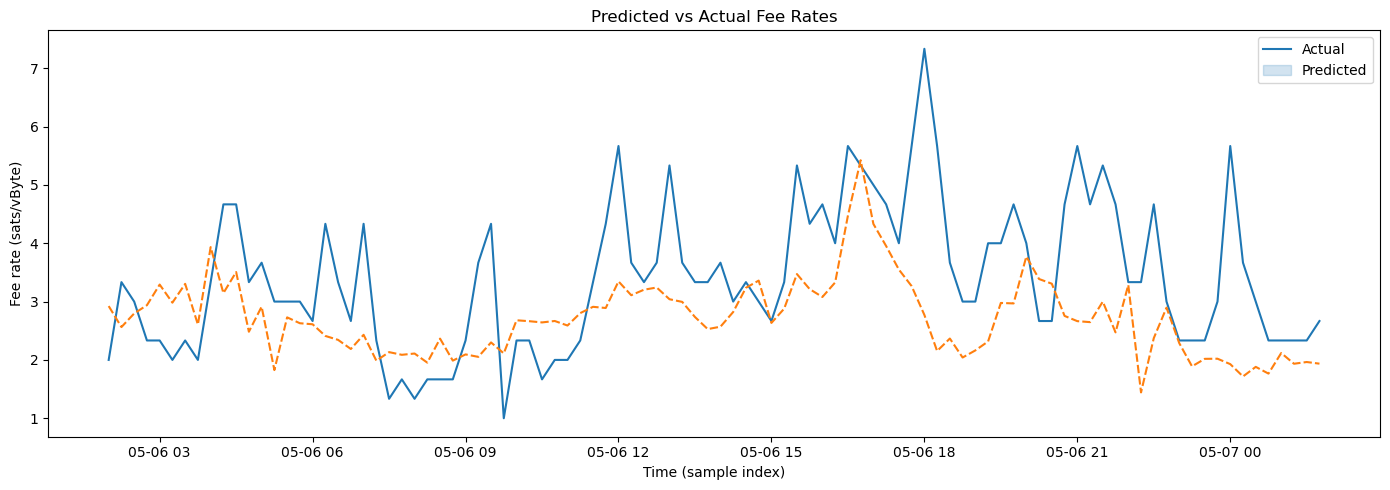

Week 10
Baseline MAE: 1.0972
Baseline RMSE: 1.2883
Baseline MAPE: 0.6267
Baseline MAE with std penelty: 2.0970
MAE: 3.5208
RMSE: 3.6600
MAPE: 1.4697
MAE with std penelty: 4.5206


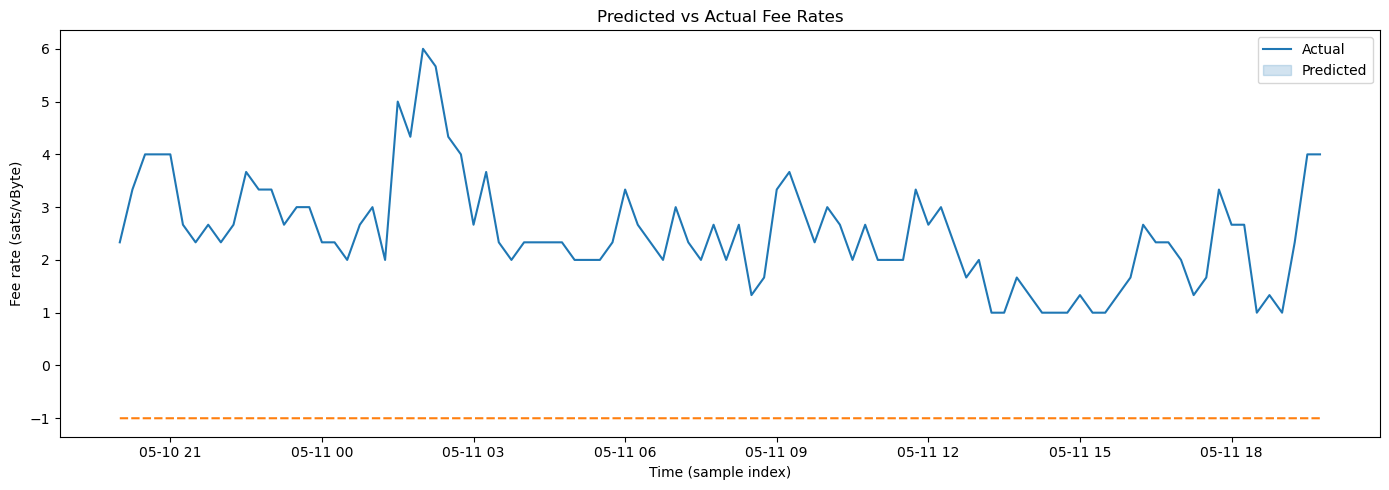



Average values: 
MAE: 1797984.5379
RMSE: 2104035.6191
MAPE: 855393.1319
MAE with std penelty: 2890759.5805
Baseline MAE: 1.4462
Baseline RMSE: 2.2699
Baseline MAPE: 0.3627
Baseline MAE with std penelty: 3.4805


In [59]:
avg_mae = 0
avg_rmse = 0
avg_mape = 0
avg_mae_std = 0

base_avg_mae = 0
base_avg_rmse = 0
base_avg_mape = 0
base_avg_mae_std = 0

## Week 1 to Week 10
for i in range(10):
    print("Week",(i+1))
    df_sliding = df_new[0+i*7*96:7*96+i*7*96]

    X = df_sliding.drop(columns = "recommended_fee_fastestFee")
    y = df_sliding["recommended_fee_fastestFee"]

    # shift
    shift_steps = 96 # shift 24h
    X = X.shift(periods=shift_steps)
    X.dropna(inplace=True)
    y = y.loc[X.index]

    split_index = len(y) - 96
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    df_prophet = y_train.reset_index()
    df_prophet = df_prophet.rename(columns={
        'timestamp': 'ds',
        'recommended_fee_fastestFee': 'y'
    })
    df_prophet['y'] = np.log1p(df_prophet['y'])

    # baseline
    y_baseline = [y_train.median()] * len(y_test)

    model = create_model_new()

    # add external features
    X_col = X_train.reset_index()
    X_col = X_col.drop(columns = "timestamp")
    for i in X_col.columns.values:
        df_prophet[i] = X_col[i].copy()
        model.add_regressor(i)

    model.fit(df_prophet)
    future = model.make_future_dataframe(periods=96, freq='15min')

    # add external features
    for i in X.columns.values:
        future[i] = list(df_prophet[i]) + list(X_test[i])

    forecast = model.predict(future)

    y_pred_temp = forecast.iloc[-96:]
    y_pred_temp = np.expm1(y_pred_temp["yhat"])
    y_pred_temp.index =X_test.index

    mae = mean_absolute_error(y_test, y_pred_temp)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_temp))
    mape = mean_absolute_percentage_error(y_test, y_pred_temp)
    mae_std = mae_with_std_penalty(y_test, y_pred_temp)

    base_mae = mean_absolute_error(y_test, y_baseline)
    base_rmse = np.sqrt(mean_squared_error(y_test, y_baseline))
    base_mape = mean_absolute_percentage_error(y_test, y_baseline)   
    base_mae_std = mae_with_std_penalty(y_test, y_baseline)

    avg_mae += mae
    avg_rmse += rmse
    avg_mape += mape
    avg_mae_std += mae_std
    
    base_avg_mae += base_mae
    base_avg_rmse += base_rmse
    base_avg_mape += base_mape
    base_avg_mae_std += base_mae_std
    print(f"Baseline MAE: {base_mae:.4f}")
    print(f"Baseline RMSE: {base_rmse:.4f}")
    print(f"Baseline MAPE: {base_mape:.4f}")
    print(f"Baseline MAE with std penelty: {base_mae_std:.4f}")
    get_result_new(forecast,y_test,y)

avg_mae /= 10
avg_rmse /= 10
avg_mape /= 10
avg_mae_std /= 10

base_avg_mae /= 10
base_avg_rmse /= 10
base_avg_mape /= 10
base_avg_mae_std /= 10

print("\n")
print("Average values: ")
print(f"MAE: {avg_mae:.4f}")
print(f"RMSE: {avg_rmse:.4f}")
print(f"MAPE: {avg_mape:.4f}")
print(f"MAE with std penelty: {avg_mae_std:.4f}")
print(f"Baseline MAE: {base_avg_mae:.4f}")
print(f"Baseline RMSE: {base_avg_rmse:.4f}")
print(f"Baseline MAPE: {base_avg_mape:.4f}")
print(f"Baseline MAE with std penelty: {base_avg_mae_std:.4f}")

The performance is far from good. Because Prophet is not a lag-aware or sequence-based model. 

The performance is far from good. Because Prophet is not a lag-aware or sequence-based model. 

## Set holidays

Prophet also supports manually setting holiday parameters. In this case, we found the best choice was to define holidays as the timestamps corresponding to the top 10% of the values. The log-transformed values increased by 25% percent in holidays compared to the baseline trend. 

In [60]:
def create_model_new_holiday(y_train):
    s = y_train.reset_index()
    threshold = s['recommended_fee_fastestFee'].quantile(0.9)
    spike_times = s[s['recommended_fee_fastestFee'] > threshold]['timestamp']

    # holidays dataframe
    holidays = pd.DataFrame({
        'ds': pd.to_datetime(spike_times),
        'holiday': 'congestion_spike'
    })

    # remove duplicate
    holidays = holidays.drop_duplicates(subset='ds')
    model = Prophet(
        daily_seasonality=False,
        weekly_seasonality=False,
        changepoint_prior_scale = 0.01,
        seasonality_prior_scale=10.0,
        seasonality_mode='multiplicative',
        changepoint_range=0.9,
        n_changepoints=25,
        holidays=holidays
    )

    model.add_seasonality(name='hourly', period=1/24, fourier_order=5) 
    model.add_seasonality(name='daily', period=1, fourier_order=10)  
    model.add_seasonality(name='weekly', period=24, fourier_order=5) 

    return model


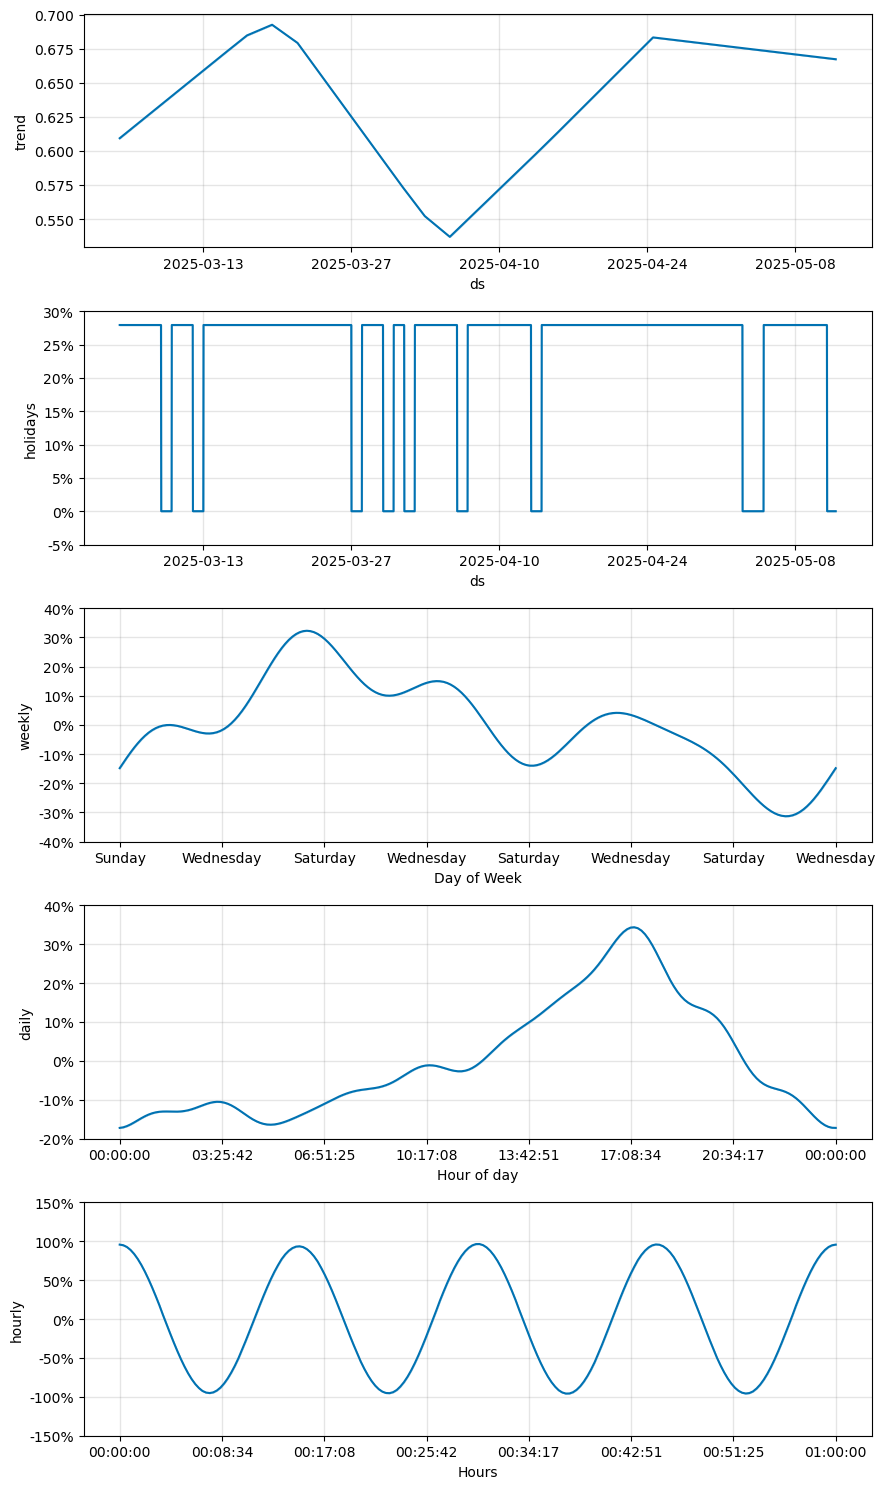

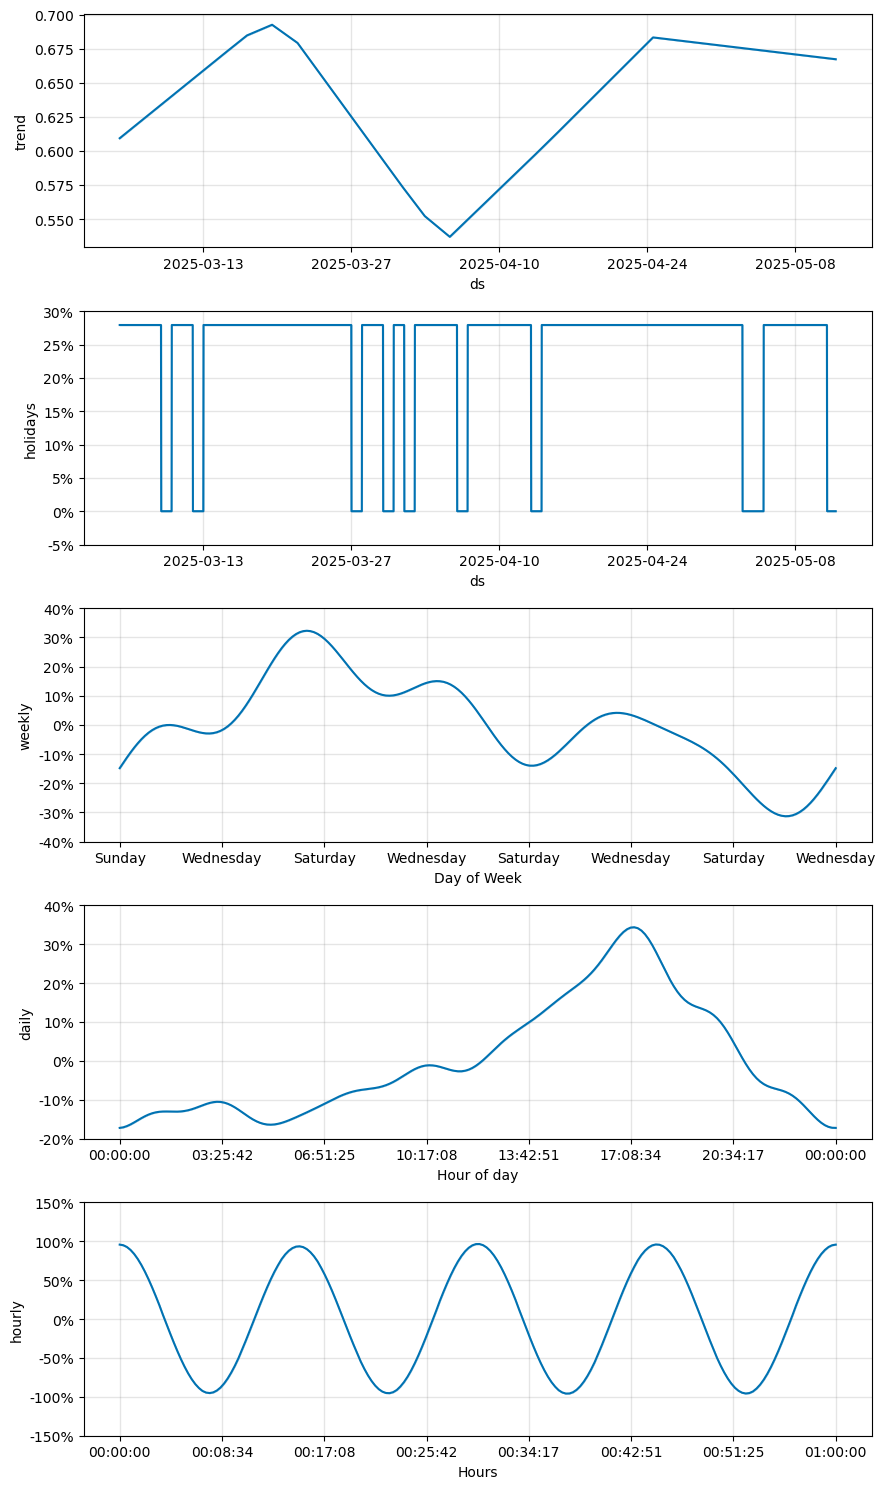

In [61]:
model_holiday = create_model_new_holiday(y_train_new)
model_holiday.fit(df_prophet_new)
future = model_holiday.make_future_dataframe(periods=96, freq='15min')
forecast = model_holiday.predict(future)
model_holiday.plot_components(forecast)

MAE: 1.0098
RMSE: 1.3430
MAPE: 0.5807
MAE with std penelty: 1.5017


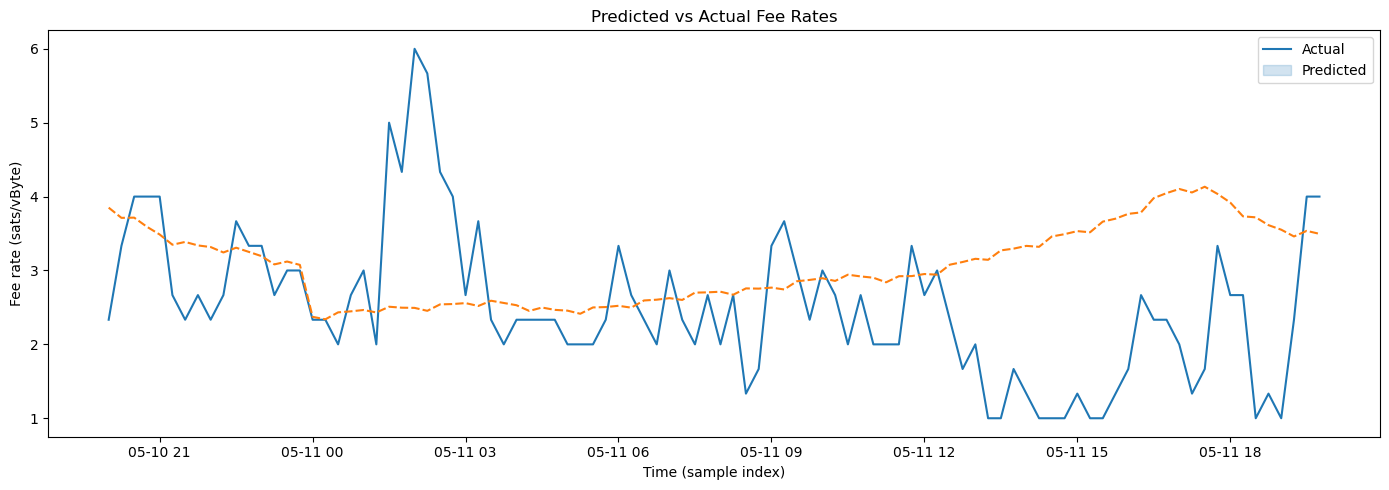

In [62]:
get_result_new(forecast,y_test_new,y_new)

Week 1
Baseline MAE: 1.4306
Baseline RMSE: 2.4995
Baseline MAPE: 0.2715
Baseline MAE with std penelty: 3.6626
MAE: 1.8468
RMSE: 2.2913
MAPE: 0.5684
MAE with std penelty: 3.3727


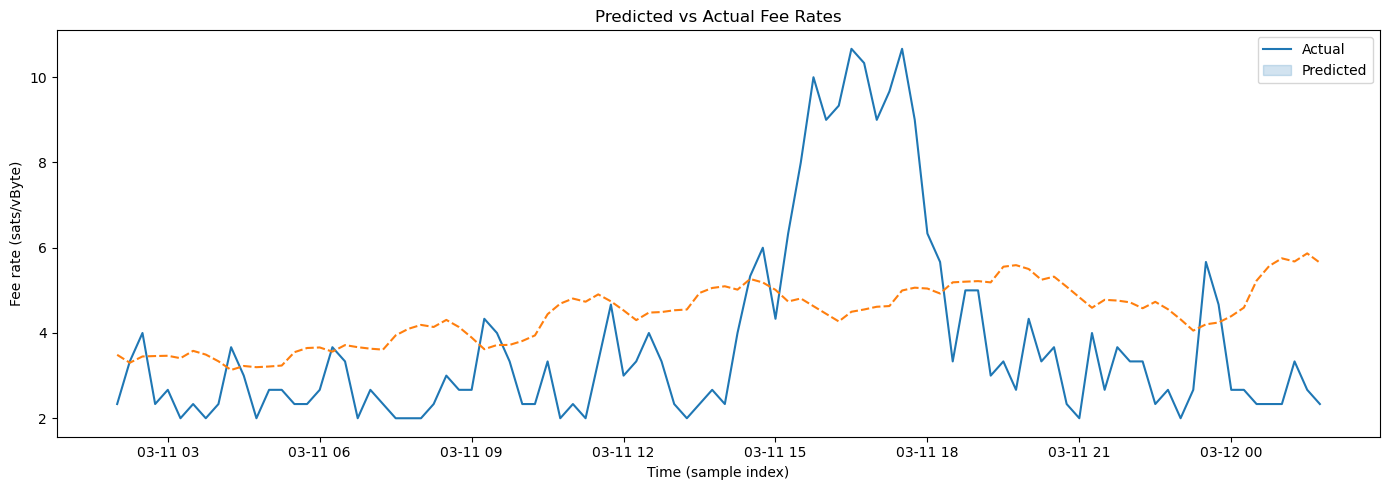

Week 2
Baseline MAE: 0.6632
Baseline RMSE: 0.8627
Baseline MAPE: 0.2271
Baseline MAE with std penelty: 1.5182
MAE: 0.7164
RMSE: 0.9364
MAPE: 0.2704
MAE with std penelty: 0.9039


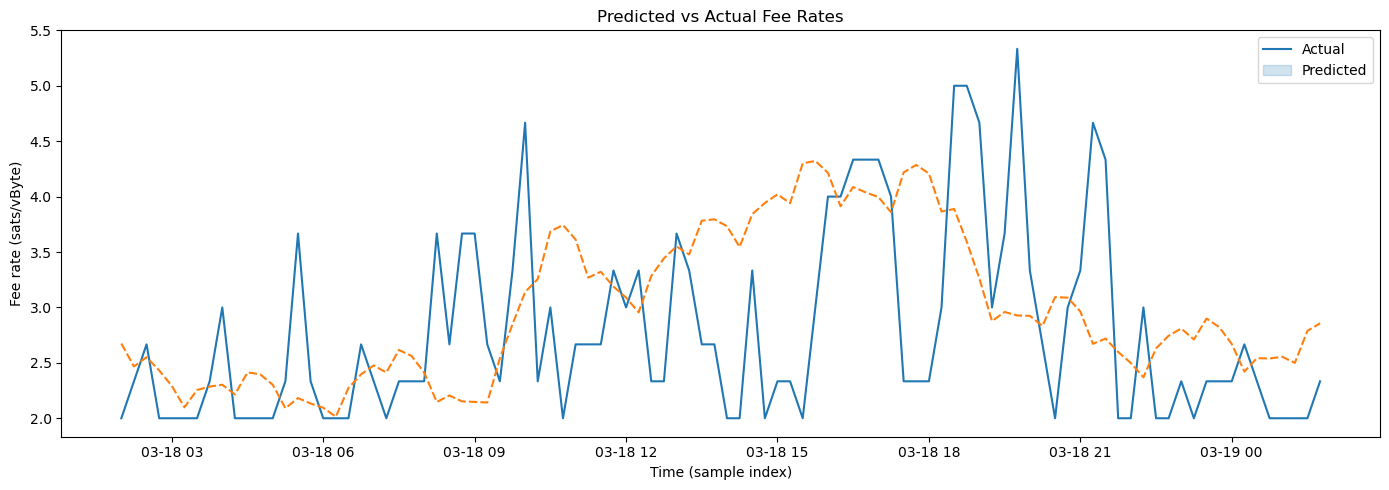

Week 3
Baseline MAE: 5.3958
Baseline RMSE: 10.4472
Baseline MAPE: 0.4088
Baseline MAE with std penelty: 14.5536
MAE: 5.1139
RMSE: 9.5081
MAPE: 0.5529
MAE with std penelty: 12.3713


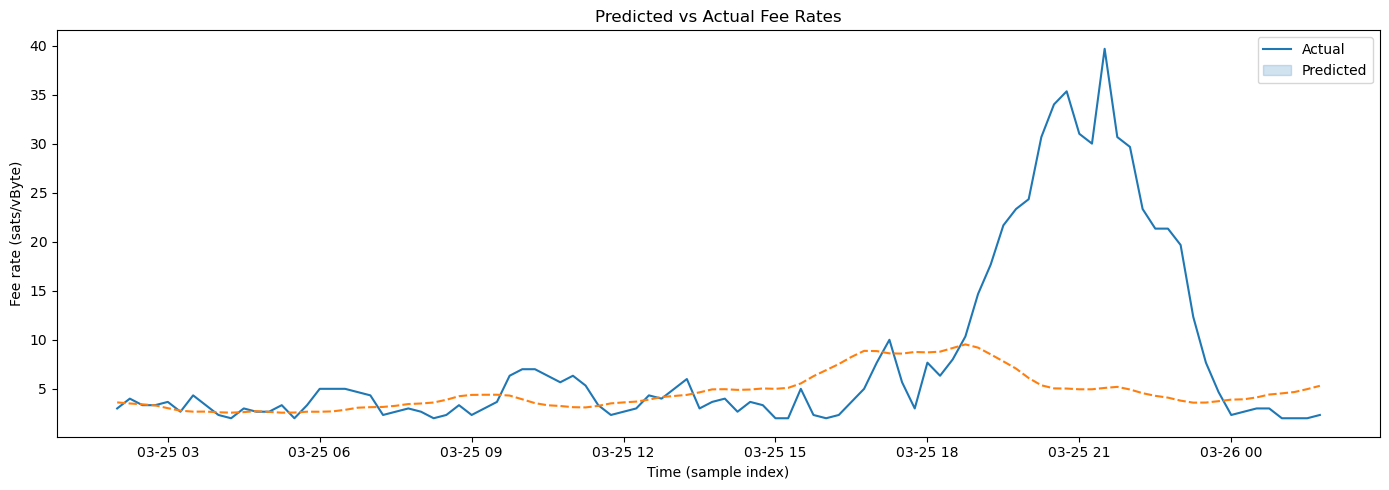

Week 4
Baseline MAE: 0.8264
Baseline RMSE: 0.9682
Baseline MAPE: 0.4462
Baseline MAE with std penelty: 1.7928
MAE: 0.8657
RMSE: 1.0752
MAPE: 0.4275
MAE with std penelty: 1.3666


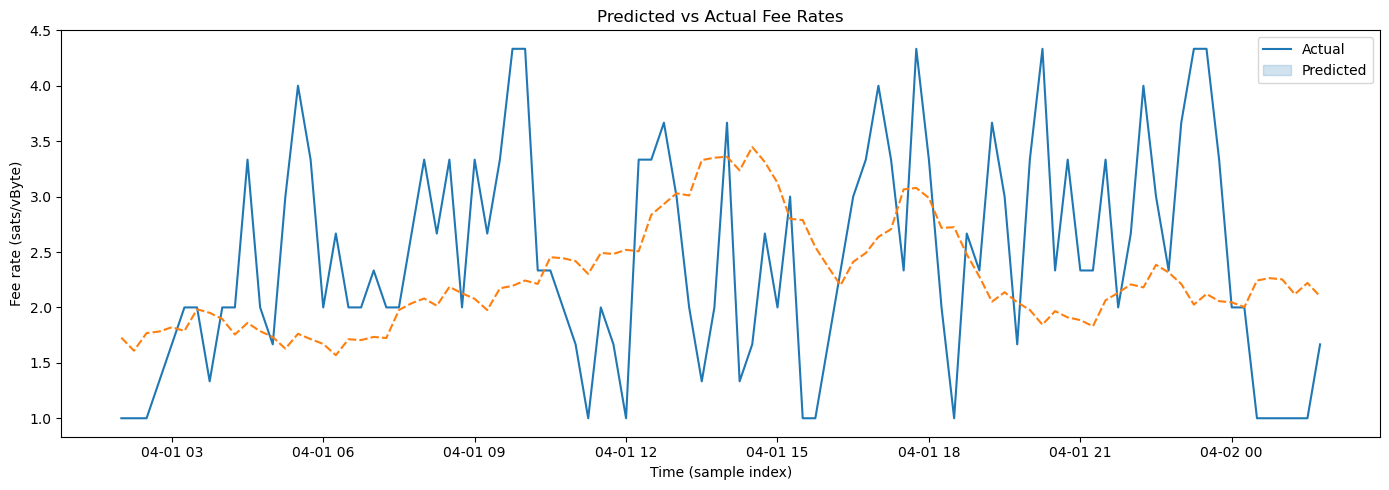

Week 5
Baseline MAE: 1.2361
Baseline RMSE: 1.6618
Baseline MAPE: 0.5004
Baseline MAE with std penelty: 2.8072
MAE: 1.2168
RMSE: 1.6149
MAPE: 0.5449
MAE with std penelty: 2.1046


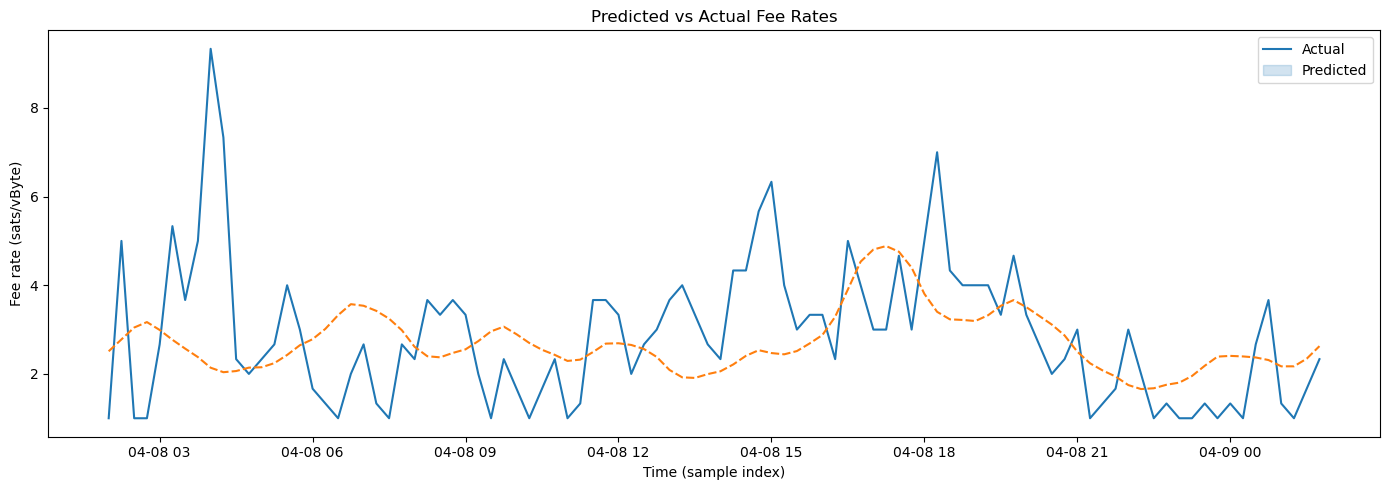

Week 6
Baseline MAE: 1.0174
Baseline RMSE: 1.3484
Baseline MAPE: 0.3554
Baseline MAE with std penelty: 2.2067
MAE: 1.1781
RMSE: 1.5421
MAPE: 0.3681
MAE with std penelty: 2.0646


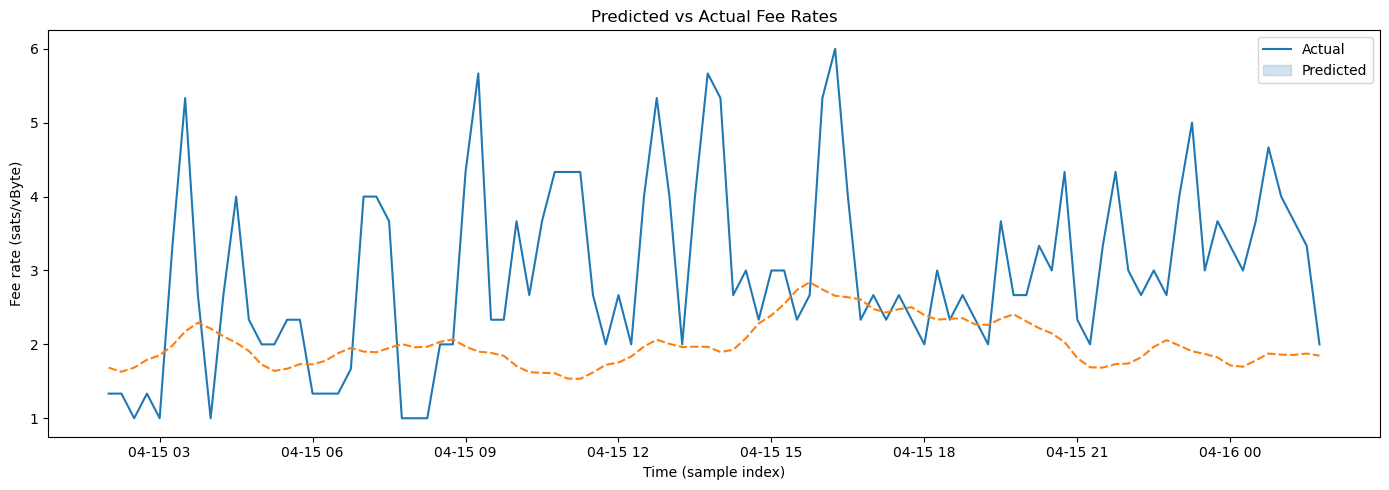

Week 7
Baseline MAE: 0.8715
Baseline RMSE: 1.0892
Baseline MAPE: 0.2773
Baseline MAE with std penelty: 1.9578
MAE: 0.8219
RMSE: 0.9932
MAPE: 0.2682
MAE with std penelty: 1.4042


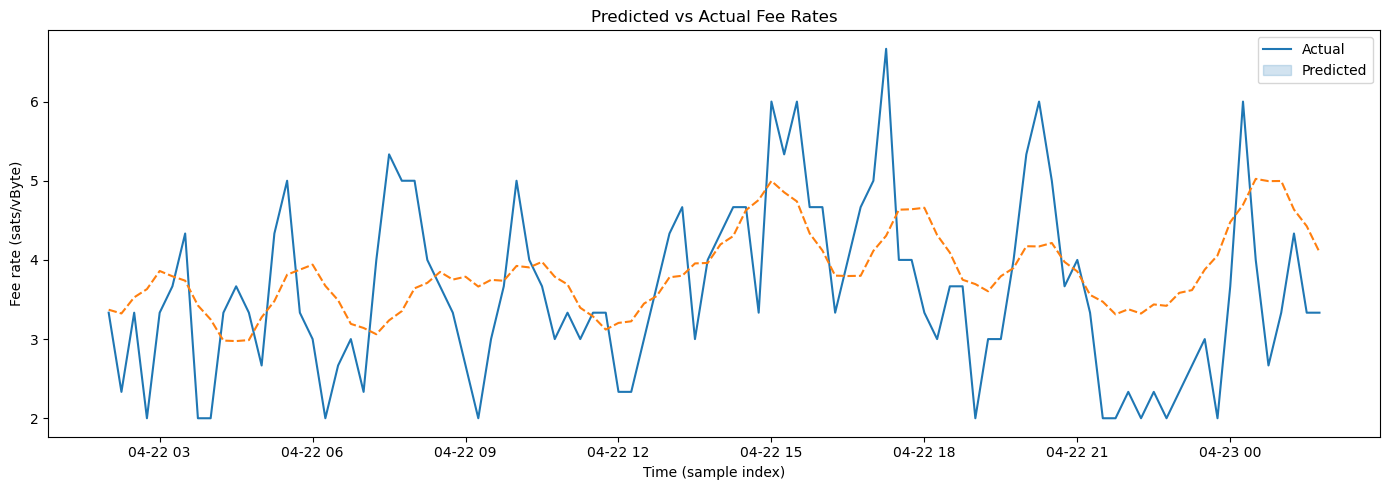

Week 8
Baseline MAE: 0.8438
Baseline RMSE: 1.0924
Baseline MAPE: 0.2407
Baseline MAE with std penelty: 1.8955
MAE: 1.4890
RMSE: 1.8472
MAPE: 0.3763
MAE with std penelty: 1.8792


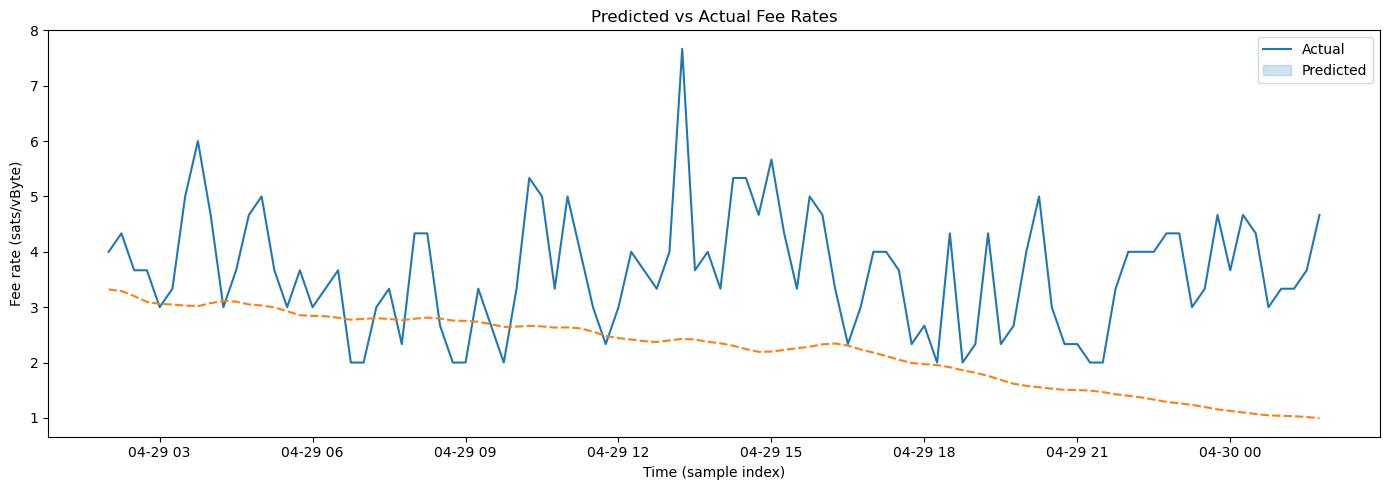

Week 9
Baseline MAE: 1.1042
Baseline RMSE: 1.4369
Baseline MAPE: 0.3126
Baseline MAE with std penelty: 2.3382
MAE: 0.9690
RMSE: 1.2884
MAPE: 0.2727
MAE with std penelty: 1.9094


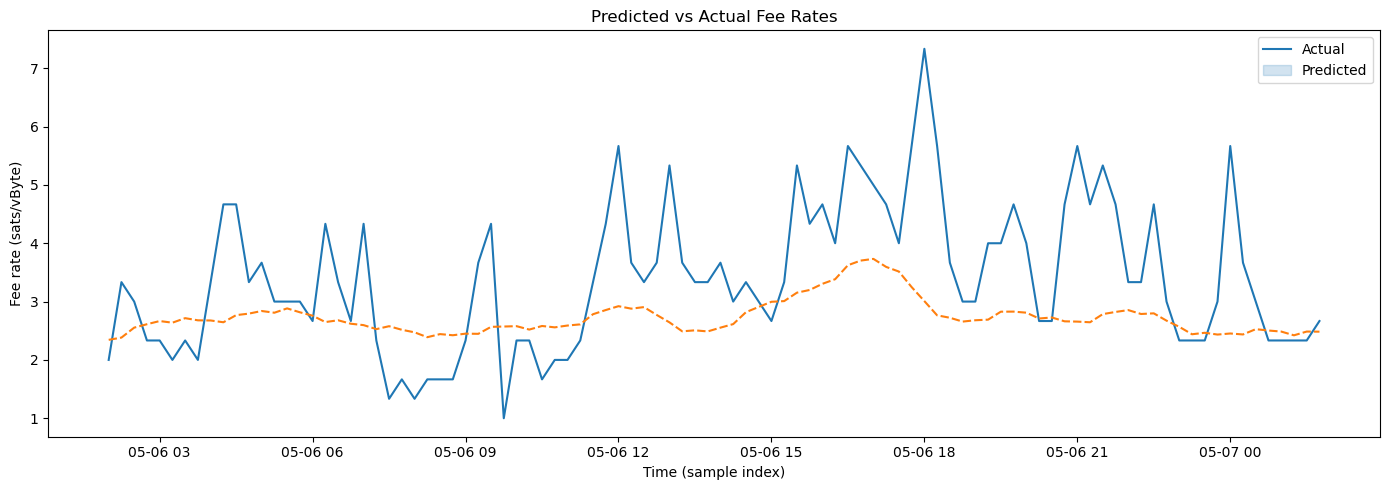

Week 10
Baseline MAE: 1.0972
Baseline RMSE: 1.2883
Baseline MAPE: 0.6267
Baseline MAE with std penelty: 2.0970
MAE: 1.7407
RMSE: 1.9800
MAPE: 0.6610
MAE with std penelty: 2.3755


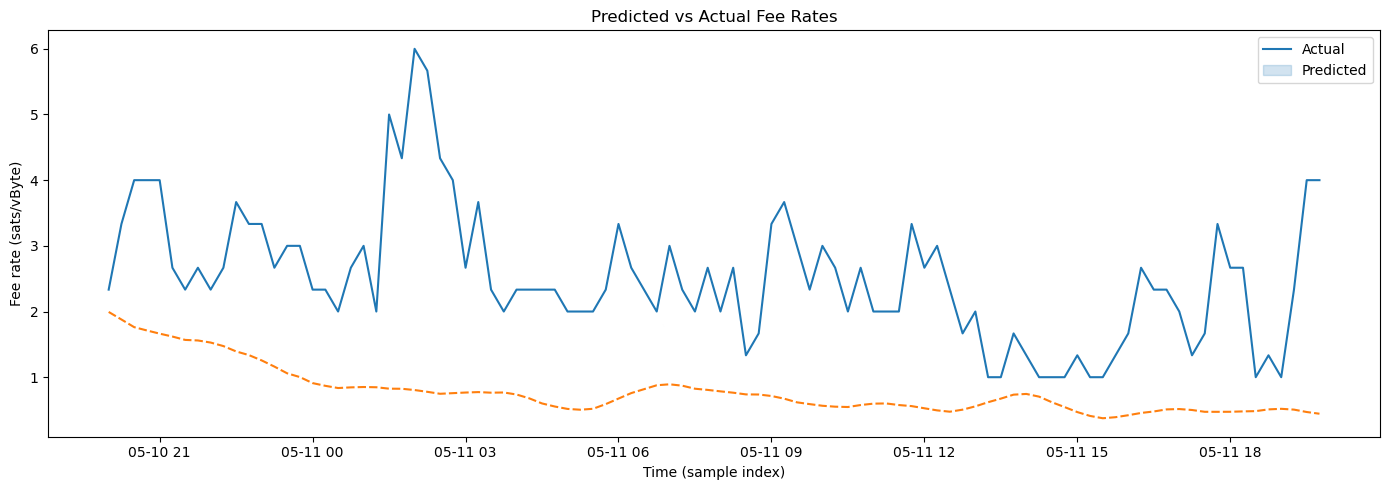



Average values: 
MAE: 1.5958
RMSE: 2.3077
MAPE: 0.4310
MAE with std penelty: nan
Baseline MAE: 1.4486
Baseline RMSE: 2.2695
Baseline MAPE: 0.3667
Baseline MAE with std penelty: 0.0000


In [69]:
avg_mae = 0
avg_rmse = 0
avg_mape = 0
avg_mae_std = 0

base_avg_mae = 0
base_avg_rmse = 0
base_avg_mape = 0
base_avg_mae_std = 0

## Week 1 to Week 10
for i in range(10):
    print("Week",(i+1))
    df_sliding = df_new[0+i*7*96:7*96+i*7*96]
    y = df_sliding["recommended_fee_fastestFee"]
    split_index = len(y) - 96
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    df_prophet = y_train.reset_index()
    df_prophet = df_prophet.rename(columns={
        'timestamp': 'ds',
        'recommended_fee_fastestFee': 'y'
    })
    df_prophet['y'] = np.log1p(df_prophet['y'])

    # baseline
    y_baseline = [y_train.median()] * len(y_test)

    model = create_model_new_holiday(y_train)
    model.fit(df_prophet)
    future = model.make_future_dataframe(periods=96, freq='15min')
    forecast = model.predict(future)

    y_pred_temp = forecast.iloc[-96:]
    y_pred_temp = np.expm1(y_pred_temp["yhat"])
    y_pred_temp.index =X_test.index

    mae = mean_absolute_error(y_test, y_pred_temp)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_temp))
    mape = mean_absolute_percentage_error(y_test, y_pred_temp)
    mae_std = mae_with_std_penalty(y_test, y_pred_temp)

    base_mae = mean_absolute_error(y_test, y_baseline)
    base_rmse = np.sqrt(mean_squared_error(y_test, y_baseline))
    base_mape = mean_absolute_percentage_error(y_test, y_baseline)   
    base_mae_std = mae_with_std_penalty(y_test, y_baseline)

    avg_mae += mae
    avg_rmse += rmse
    avg_mape += mape
    avg_mae_std += mae_std
    
    base_avg_mae += base_mae
    base_avg_rmse += base_rmse
    base_avg_mape += base_mape
    base_avg_mae_std += base_avg_mae_std
    print(f"Baseline MAE: {base_mae:.4f}")
    print(f"Baseline RMSE: {base_rmse:.4f}")
    print(f"Baseline MAPE: {base_mape:.4f}")
    print(f"Baseline MAE with std penelty: {base_mae_std:.4f}")
    get_result_new(forecast,y_test,y)

avg_mae /= 10
avg_rmse /= 10
avg_mape /= 10
avg_mae_std /= 10

base_avg_mae /= 10
base_avg_rmse /= 10
base_avg_mape /= 10
base_avg_mae_std /= 10

print("\n")
print("Average values: ")
print(f"MAE: {avg_mae:.4f}")
print(f"RMSE: {avg_rmse:.4f}")
print(f"MAPE: {avg_mape:.4f}")
print(f"MAE with std penelty: {avg_mae_std:.4f}")
print(f"Baseline MAE: {base_avg_mae:.4f}")
print(f"Baseline RMSE: {base_avg_rmse:.4f}")
print(f"Baseline MAPE: {base_avg_mape:.4f}")
print(f"Baseline MAE with std penelty: {base_avg_mae_std:.4f}")

## The best model

Based on the results, model with manual set holiday parameters performs the best. Then we would use the model to train the whole data.

In [67]:
y = df_new["recommended_fee_fastestFee"]
split_index = len(y) - 96
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
df_prophet = y_train.reset_index()
df_prophet = df_prophet.rename(columns={
    'timestamp': 'ds',
    'recommended_fee_fastestFee': 'y'
})
df_prophet['y'] = np.log1p(df_prophet['y'])

# baseline
y_baseline = [y_train.median()] * len(y_test)

model = create_model_new_holiday(y_train)
model.fit(df_prophet)
future = model.make_future_dataframe(periods=96, freq='15min')
forecast = model.predict(future)

y_pred_temp = forecast.iloc[-96:]
y_pred_temp = np.expm1(y_pred_temp["yhat"])
y_pred_temp.index =X_test.index

base_mae = mean_absolute_error(y_test, y_baseline)
base_rmse = np.sqrt(mean_squared_error(y_test, y_baseline))
base_mape = mean_absolute_percentage_error(y_test, y_baseline)   
base_mae_std = mae_with_std_penalty(y_test, y_baseline)

Baseline MAE: 0.9097
Baseline RMSE: 1.1087
Baseline MAPE: 0.5078
BaselineMAE with std penelty: 1.9095
MAE: 1.0098
RMSE: 1.3430
MAPE: 0.5807
MAE with std penelty: 1.5017


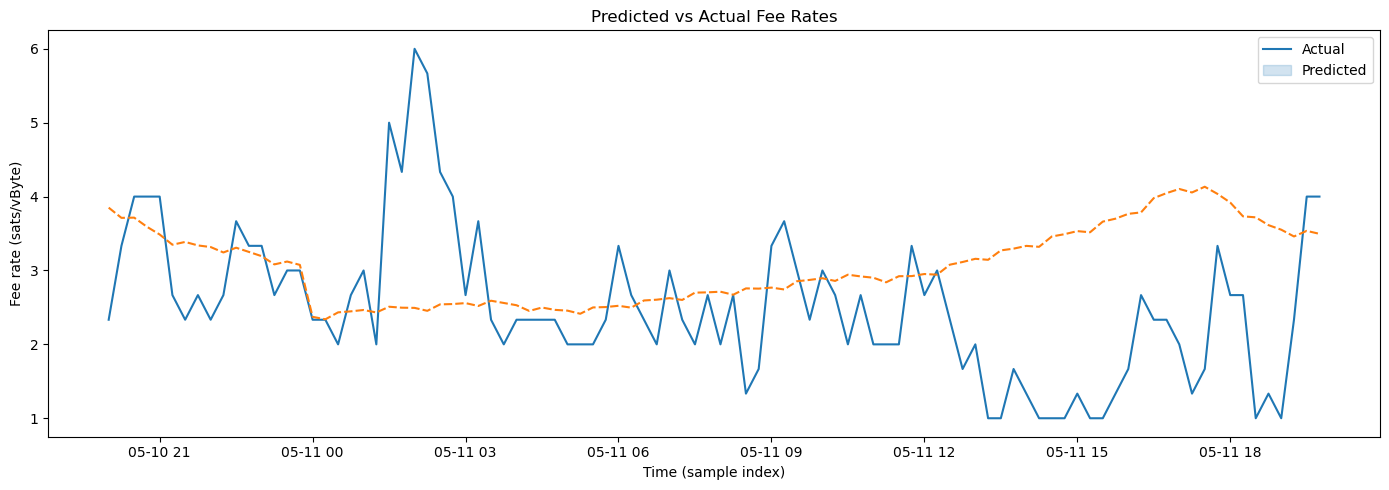

In [68]:
print(f"Baseline MAE: {base_mae:.4f}")
print(f"Baseline RMSE: {base_rmse:.4f}")
print(f"Baseline MAPE: {base_mape:.4f}")
print(f"BaselineMAE with std penelty: {base_mae_std:.4f}")
get_result_new(forecast,y_test,y)

## Conclusion

The performance is not as good as baseline. We should try other advanced models.